<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Covid_python_with_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Trends Prediction in Thailand Using Time Series Neural Networks

---


We used convolutional neural network (CNN), recurrent neural networks (RNNs), gated recurrent unit (GRU) and long short-term memory (LSTM) to predict Covid-19 cases and deaths in Thailand, using 14 previous days as samples to predict the next 1 day. These models particularly deal with time series data. Further, we ran multivariate neural networks with policy implementations, mobility changes, transportation behavior changes, vaccination, confirmed cases (for predicting deaths) and confirmed deaths (for predicting cases) as additional predictors. Our goal was to minimize the mean average percentage error (MAPE) between the actual values and predictions.  



## Data Sources


The Covid-19 data was from https://github.com/CSSEGISandData/COVID-19 by John Hopkins University. The data included both confirmed infects and confirmed deaths reported by Thailand’s Ministry of Public Health. 
Policy implementation in Thailand data was gathered by Oxford Covid-19 Government Response Tracker (OxCGRT) (https://github.com/OxCGRT/covid-policy-tracker). This policy record indicated when and how the government in each country responded to the pandemic at specific time periods. We used containment and health index which consisted of school closing, workplace closing, canceling public events, restrictions on gatherings, close public transport, stay at home requirements, international travel controls, and public information campaign. Each indicator was coded in different levels of implementations (see more: ​​https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md)
The mobility data was from Google (https://www.google.com/covid19/mobility). Google calculated the changes of mobility based on Location History of users on Google Map. The baseline of the changes was the median value from January, 3rd to February 6th, 2020. There were four categories: groceries and pharmacy, retail and recreation, transit stations, and finally, parks. Another source of mobility was from Apple where it tracked driving and walking behaviors during the pandemic (https://covid19.apple.com/mobility). 
Vaccination count was gathered from Thailand’s Ministry of Health (https://github.com/porames/the-researcher-covid-data?fbclid=IwAR1-SAiA8pMKD5qbcN7S5c-p_snBIIWd42wYOq4qiM9yA6FTf_GcyYgxtvA). This vaccination information that was used in this study was the amount of Thai people who received their first shot, second shot of vaccines, regardless of the vaccine types. 
Finally, the last input data was transportation behavior from Thai’s Ministry of Transportation (https://datagov.mot.go.th/dataset/covid-19/resource/71a552d0-0fea-4e05-b78c-42d58aa88db6?fbclid=IwAR18p4TQY3qlD9snnhADdvrAWVjOgofse54GbNKm8Qb-pMgBb-ZejebWD-w). The information included the rate of use for both public and private transportation systems in Thailand. 



## Import packages

In [1]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical

     |████████████████████████████████| 1.1 MB 4.9 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [95]:
data = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

data = pd.DataFrame(data)

# select Thailand only
data = data.loc[data['CountryName'] == "Thailand"]

# select columns
data = data[["Date","ConfirmedCases", "ConfirmedDeaths"]]

# change date format
data.Date =  pd.to_datetime(data["Date"], format='%Y%m%d')

# reset index
data = data.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths (before infect found)
data[["ConfirmedCases", "ConfirmedDeaths"]] = data[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# remove NaN rows (bottom part)
data = data.dropna()

# add daily cases columns
data[["Cases_daily"]] = data['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
data[["Deaths_daily"]] = data['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# # replace NaN with 0 for ConfirmedCases and Deaths_daily
data[["Cases_daily", "Deaths_daily"]] = data[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)

# reset index
data = data.reset_index(drop = True)

# start from 15/2/2020
data = data[data.loc[data['Date'] == "2020-02-15"].index[0]:]

# remove the last rows with incomplete info
data = data.loc[~(data[["ConfirmedCases"]]==0).all(axis=1)]

# reset index
data = data.reset_index(drop = True)

# data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [97]:
mob = read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

mob = pd.DataFrame(mob)

# select only Thailand
mob = mob.loc[mob['country_region'] == "Thailand"]

# select columns
mob = mob[["date",
              "retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline",
              "residential_percent_change_from_baseline"]]

# change date format
mob.date =  pd.to_datetime(mob["date"])

# change column name
mob = mob.rename(columns = {'date':'Date',
                            "retail_and_recreation_percent_change_from_baseline":'retail',
                            "grocery_and_pharmacy_percent_change_from_baseline": "grocery",
                            "parks_percent_change_from_baseline":'parks',
                            "transit_stations_percent_change_from_baseline":"transit",
                            "workplaces_percent_change_from_baseline":"workplace",
                            "residential_percent_change_from_baseline":"resident"})

# reset index
mob = mob.reset_index(drop = True)

# start from 15/2/2020
mob = mob[mob.loc[mob['Date'] == "2020-02-15"].index[0]:]

# omit Date column
mob0 = mob.drop(["Date"], axis = 1)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [98]:
# whichever has fewer data
length = min(len(data), len(mob))

# Cases daily
data_i = pd.concat([data.Cases_daily[:length],
                    data.Date[:length], 
                    mob0[:length]], axis = 1)

data_i = data_i.rename(columns = {"Cases_daily":"data_i"})
data_i = data_i[data_i.loc[data_i['Date'] == "2021-06-15"].index[0]:]

# drop date column
data_i = data_i.drop(["Date"], axis = 1)

# reset index
data_i = data_i.reset_index(drop = True)

# Deaths daily
data_d = pd.concat([data.Deaths_daily[:length], 
                    data.Date[:length],
                    mob0[:length]], axis = 1)

data_d = data_d.rename(columns = {"Deaths_daily":"data_d"})
data_d = data_d[data_d.loc[data_d['Date'] == "2021-06-15"].index[0]:]

# drop date column
data_d = data_d.drop(["Date"], axis = 1)

# reset index
data_d = data_d.reset_index(drop = True)

In [102]:
case = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

case = pd.DataFrame(case)

# select Thailand only
case = case.loc[case['CountryName'] == "Thailand"]

case = case[["Date", "ConfirmedCases", "ConfirmedDeaths"]]

# change date format
case.Date =  pd.to_datetime(case["Date"], format='%Y%m%d')

# reset index
case = case.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
case[["ConfirmedCases", "ConfirmedDeaths"]] = case[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# add daily cases columns
case[["Cases_daily"]] = case['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
case[["Deaths_daily"]] = case['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
case[["Cases_daily", "Deaths_daily"]] = case[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)

# start from 15/2/2020
case = case[case.loc[case['Date'] == "2020-02-15"].index[0]:]


# remove the last rows with incomplete info
case = case.loc[~(case[["ConfirmedCases"]]==0).all(axis=1)]

# reset index
case = case.reset_index(drop = True)

# case


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [101]:
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]
mob = mob[mob.loc[mob['Date'] == "2021-06-15"].index[0]:]
actual = case[case.loc[case['Date'] == "2021-06-15"].index[0]:]


## Import data

In [103]:

# use the previous 14 days to predict the next day
lag = 14
prediction = 1
window = 3 # for moving average

# moving average
data_i['data_i'] = data_i.data_i.rolling(window).mean()
data_d['data_d'] = data_d.data_d.rolling(window).mean()

# remove NaN
data.dropna(subset = ["Cases_daily", "Deaths_daily"], inplace=True)
data_i.dropna(subset = ["data_i"], inplace=True)
data_d.dropna(subset = ["data_d"], inplace=True)

data = data.reset_index(drop = True)
data_i = data_i.reset_index(drop = True)
data_d = data_d.reset_index(drop = True)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Methods

---


The data was available from February 22nd, 2020 to September 9th, 2021 (as the date the data was retrieved). However, the third wave of the epidemic in Thailand started after April 1st, 2021, and the trend started to rise after June. Thus, we used the data from, June 15th to July 29th, 2021 for our training; July 30th to August 18th, 2021 for our validation, and August 19th to September 2nd, 2021 for our prediction. There were 31 samples in total for training, 20 samples for validation, and predictions of 15 days ahead. 

Since confirmed cases, confirmed deaths and vaccination data were given in cumulative counts, we computed the daily cases, deaths and vaccination to match the format of other predictors: mobility and transportation changes. Neural networks required input and output in forms of matrices. The experiments consisted of univariate and multivariate approaches for training, validation, and prediction

For the univariate, we created an input matrix with 14 columns as the previous 14 days input. The number of rows was equal to total samples - 14 days - 1-day prediction + 1 or 31 rows. To demonstrate, the first row would have the 1st to the 14th day. The second row would have the 2nd to the 15th day, and so forth as a rolling window. The output matrix would be the 1 column for 1-day prediction with the same amount of rows as the input matrix. For example, the first row would be the 15th day for the 1-day prediction. Since the neural networks could only work with at least 2 dimensions, we transformed both input and output matrices into 3 dimensions (with 1 as the third dimension).

## Data Preprocessing: Multivariate

In [104]:
def split_sequence(sequence, lag):
  x, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + lag
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    x.append(seq_x)
    y.append(seq_y)
  return array(x), array(y)

index = 30

In [105]:
# confirmed cases
nrow_total = data_i.shape[0] - lag - prediction + 1

y_i = np.array([data_i.data_i[lag:data_i.shape[0]]])
y_i = y_i.T # transpose the matrix

# split into training and test sets
# retail
input_list = [np.expand_dims(data_i[i:lag+i][["retail", "data_i"]], axis=0) for i in range(nrow_total)] 
X_i = np.concatenate(input_list, axis=0)
X_i_tr_retail = X_i[0:index+1, :, :]
X_i_ts_retail = X_i[index+1:data_i.shape[0], :, :]

# grocery
input_list = [np.expand_dims(data_i[i:lag+i][["grocery", "data_i"]], axis=0) for i in range(nrow_total)] 
X_i = np.concatenate(input_list, axis=0)
X_i_tr_grocery = X_i[0:index+1, :, :]
X_i_ts_grocery = X_i[index+1:data_i.shape[0], :, :]

# parks
input_list = [np.expand_dims(data_i[i:lag+i][["parks", "data_i"]], axis=0) for i in range(nrow_total)] 
X_i = np.concatenate(input_list, axis=0)
X_i_tr_parks = X_i[0:index+1, :, :]
X_i_ts_parks = X_i[index+1:data_i.shape[0], :, :]

# transit
input_list = [np.expand_dims(data_i[i:lag+i][["transit", "data_i"]], axis=0) for i in range(nrow_total)] 
X_i = np.concatenate(input_list, axis=0)
X_i_tr_transit = X_i[0:index+1, :, :]
X_i_ts_transit = X_i[index+1:data_i.shape[0], :, :]

# workplace
input_list = [np.expand_dims(data_i[i:lag+i][["workplace", "data_i"]], axis=0) for i in range(nrow_total)] 
X_i = np.concatenate(input_list, axis=0)
X_i_tr_workplace = X_i[0:index+1, :, :]
X_i_ts_workplace = X_i[index+1:data_i.shape[0], :, :]

# resident
input_list = [np.expand_dims(data_i[i:lag+i][["resident", "data_i"]], axis=0) for i in range(nrow_total)] 
X_i = np.concatenate(input_list, axis=0)
X_i_tr_resident = X_i[0:index+1, :, :]
X_i_ts_resident = X_i[index+1:data_i.shape[0], :, :]


y_i_tr = y_i[0:index+1]
y_i_ts = y_i[index+1:data_i.shape[0]]

# confirmed deaths
nrow_total = data_d.shape[0] - lag - prediction + 1

y_d = np.array([data_d.data_d[lag:data_d.shape[0]]])
y_d = y_d.T # transpose the matrix


# split into training and test sets
# retail
input_list = [np.expand_dims(data_d[i:lag+i][["retail", "data_d"]], axis=0) for i in range(nrow_total)] 
X_d = np.concatenate(input_list, axis=0)
X_d_tr_retail = X_d[0:index+1, :, :]
X_d_ts_retail = X_d[index+1:data_d.shape[0], :, :]

# grocery
input_list = [np.expand_dims(data_d[i:lag+i][["grocery", "data_d"]], axis=0) for i in range(nrow_total)] 
X_d = np.concatenate(input_list, axis=0)
X_d_tr_grocery = X_d[0:index+1, :, :]
X_d_ts_grocery = X_d[index+1:data_d.shape[0], :, :]

# parks
input_list = [np.expand_dims(data_d[i:lag+i][["parks", "data_d"]], axis=0) for i in range(nrow_total)] 
X_d = np.concatenate(input_list, axis=0)
X_d_tr_parks = X_d[0:index+1, :, :]
X_d_ts_parks = X_d[index+1:data_d.shape[0], :, :]

# transit
input_list = [np.expand_dims(data_d[i:lag+i][["transit", "data_d"]], axis=0) for i in range(nrow_total)] 
X_d = np.concatenate(input_list, axis=0)
X_d_tr_transit = X_d[0:index+1, :, :]
X_d_ts_transit = X_d[index+1:data_d.shape[0], :, :]

# workplace
input_list = [np.expand_dims(data_d[i:lag+i][["workplace", "data_d"]], axis=0) for i in range(nrow_total)] 
X_d = np.concatenate(input_list, axis=0)
X_d_tr_workplace = X_d[0:index+1, :, :]
X_d_ts_workplace = X_d[index+1:data_d.shape[0], :, :]

# resident
input_list = [np.expand_dims(data_d[i:lag+i][["resident", "data_d"]], axis=0) for i in range(nrow_total)] 
X_d = np.concatenate(input_list, axis=0)
X_d_tr_resident = X_d[0:index+1, :, :]
X_d_ts_resident = X_d[index+1:data_d.shape[0], :, :]


y_d_tr = y_d[0:index+1]
y_d_ts = y_d[index+1:data_d.shape[0]]


# Retail

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 


In [ ]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi_retail = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_tr_retail, y_i_tr)
    cnn_i_multi_retail.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr_retail, y_i_tr)
    cnn_i_multi_retail.append(score)

cnn_i_multi_retail = pd.DataFrame(cnn_i_multi_retail).T
cnn_i_multi_retail.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 5.474
filter = 4, kernel size = 3, pooling size = 2: 5.503
filter = 8, kernel size = 3, pooling size = 2: 5.854
filter = 16, kernel size = 3, pooling size = 2: 4.428
filter = 32, kernel size = 3, pooling size = 2: 4.273
filter = 64, kernel size = 3, pooling size = 2: 3.798
filter = 128, kernel size = 3, pooling size = 2: 3.742
filter = 256, kernel size = 3, pooling size = 2: 4.267
filter = 512, kernel size = 3, pooling size = 2: 4.746
filter = 1024, kernel size = 3, pooling size = 2: 4.886
filter = 2, kernel size = 5, pooling size = 2: 5.606
filter = 4, kernel size = 5, pooling size = 2: 4.751
filter = 8, kernel size = 5, pooling size = 2: 4.462
filter = 16, kernel size = 5, pooling size = 2: 3.421
filter = 32, kernel size = 5, pooling size = 2: 4.365
filter = 64, kernel size = 5, pooling size = 2: 3.858
filter = 128, kernel size = 5, pooling size = 2: 3.736
filter = 256, kernel size = 5, pooling size = 2: 4.433
filter = 512, kernel size =

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi_retail = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_retail, y_d_tr)
    cnn_d_multi_retail.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_retail, y_d_tr)
    cnn_d_multi_retail.append(score)

cnn_d_multi_retail = pd.DataFrame(cnn_d_multi_retail).T
cnn_d_multi_retail.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 11.323
filter = 4, kernel size = 3, pooling size = 2: 11.252
filter = 8, kernel size = 3, pooling size = 2: 9.561
filter = 16, kernel size = 3, pooling size = 2: 10.212
filter = 32, kernel size = 3, pooling size = 2: 9.218
filter = 64, kernel size = 3, pooling size = 2: 6.300
filter = 128, kernel size = 3, pooling size = 2: 6.138
filter = 256, kernel size = 3, pooling size = 2: 5.434
filter = 512, kernel size = 3, pooling size = 2: 5.749
filter = 1024, kernel size = 3, pooling size = 2: 7.455
filter = 2, kernel size = 5, pooling size = 2: 9.736
filter = 4, kernel size = 5, pooling size = 2: 9.468
filter = 8, kernel size = 5, pooling size = 2: 7.749
filter = 16, kernel size = 5, pooling size = 2: 7.367
filter = 32, kernel size = 5, pooling size = 2: 6.734
filter = 64, kernel size = 5, pooling size = 2: 7.114
filter = 128, kernel size = 5, pooling size = 2: 7.589
filter = 256, kernel size = 5, pooling size = 2: 8.055
filter = 512, kernel siz

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# # Univariate LSTM confirmed cases
units = [2, 4,8,16,32,64,128,256,512, 1024]


# Multivariate LSTM confirmed cases

lstm_i_multi_retail = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr_retail, y_i_tr, i)
  lstm_i_multi_retail.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi_retail = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr_retail, y_d_tr, i)
  lstm_d_multi_retail.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate GRU confirmed cases

gru_i_multi_retail = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr_retail, y_i_tr, i)
  gru_i_multi_retail.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi_retail = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr_retail, y_d_tr, i)
  gru_d_multi_retail.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate RNNs confirmed cases

rnn_i_multi_retail = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr_retail, y_i_tr, i)
  rnn_i_multi_retail.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi_retail = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr_retail, y_d_tr, i)
  rnn_d_multi_retail.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi_retail[0],3), 
                                     round(gru_i_multi_retail[0],3),
                                     round(rnn_i_multi_retail[0],3), 
                                     round(cnn_i_multi_retail.iloc[0,0],3),
                                     round(cnn_i_multi_retail.iloc[0,1],3),
                                     round(cnn_i_multi_retail.iloc[0,2],3),
                                     round(cnn_i_multi_retail.iloc[0,3],3),
                                     round(cnn_i_multi_retail.iloc[0,4],3),
                                     round(cnn_i_multi_retail.iloc[0,5],3)],
                                     [round(lstm_i_multi_retail[1],3), 
                                     round(gru_i_multi_retail[1],3),
                                     round(rnn_i_multi_retail[1],3), 
                                     round(cnn_i_multi_retail.iloc[1,0],3),
                                     round(cnn_i_multi_retail.iloc[1,1],3),
                                     round(cnn_i_multi_retail.iloc[1,2],3),
                                     round(cnn_i_multi_retail.iloc[1,3],3),
                                     round(cnn_i_multi_retail.iloc[1,4],3),
                                     round(cnn_i_multi_retail.iloc[1,5],3)],
                                     [round(lstm_i_multi_retail[2],3), 
                                     round(gru_i_multi_retail[2],3),
                                     round(rnn_i_multi_retail[2],3), 
                                     round(cnn_i_multi_retail.iloc[2,0],3),
                                     round(cnn_i_multi_retail.iloc[2,1],3),
                                     round(cnn_i_multi_retail.iloc[2,2],3),
                                     round(cnn_i_multi_retail.iloc[2,3],3),
                                     round(cnn_i_multi_retail.iloc[2,4],3),
                                     round(cnn_i_multi_retail.iloc[2,5],3)],
                                     [round(lstm_i_multi_retail[3],3), 
                                     round(gru_i_multi_retail[3],3),
                                     round(rnn_i_multi_retail[3],3), 
                                     round(cnn_i_multi_retail.iloc[3,0],3),
                                     round(cnn_i_multi_retail.iloc[3,1],3),
                                     round(cnn_i_multi_retail.iloc[3,2],3),
                                     round(cnn_i_multi_retail.iloc[3,3],3),
                                     round(cnn_i_multi_retail.iloc[3,4],3),
                                     round(cnn_i_multi_retail.iloc[3,5],3)],
                                     [round(lstm_i_multi_retail[4],3), 
                                     round(gru_i_multi_retail[4],3),
                                     round(rnn_i_multi_retail[4],3), 
                                     round(cnn_i_multi_retail.iloc[4,0],3),
                                     round(cnn_i_multi_retail.iloc[4,1],3),
                                     round(cnn_i_multi_retail.iloc[4,2],3),
                                     round(cnn_i_multi_retail.iloc[4,3],3),
                                     round(cnn_i_multi_retail.iloc[4,4],3),
                                     round(cnn_i_multi_retail.iloc[4,5],3)],
                                     [round(lstm_i_multi_retail[5],3), 
                                     round(gru_i_multi_retail[5],3),
                                     round(rnn_i_multi_retail[5],3), 
                                     round(cnn_i_multi_retail.iloc[5,0],3),
                                     round(cnn_i_multi_retail.iloc[5,1],3),
                                     round(cnn_i_multi_retail.iloc[5,2],3),
                                     round(cnn_i_multi_retail.iloc[5,3],3),
                                     round(cnn_i_multi_retail.iloc[5,4],3),
                                     round(cnn_i_multi_retail.iloc[5,5],3)],
                                     [round(lstm_i_multi_retail[6],3), 
                                     round(gru_i_multi_retail[6],3),
                                     round(rnn_i_multi_retail[6],3), 
                                     round(cnn_i_multi_retail.iloc[6,0],3),
                                     round(cnn_i_multi_retail.iloc[6,1],3),
                                     round(cnn_i_multi_retail.iloc[6,2],3),
                                     round(cnn_i_multi_retail.iloc[6,3],3),
                                     round(cnn_i_multi_retail.iloc[6,4],3),
                                     round(cnn_i_multi_retail.iloc[6,5],3)],
                                     [round(lstm_i_multi_retail[7],3), 
                                     round(gru_i_multi_retail[7],3),
                                     round(rnn_i_multi_retail[7],3), 
                                     round(cnn_i_multi_retail.iloc[7,0],3),
                                     round(cnn_i_multi_retail.iloc[7,1],3),
                                     round(cnn_i_multi_retail.iloc[7,2],3),
                                     round(cnn_i_multi_retail.iloc[7,3],3),
                                     round(cnn_i_multi_retail.iloc[7,4],3),
                                     round(cnn_i_multi_retail.iloc[7,5],3)],
                                     [round(lstm_i_multi_retail[8],3), 
                                     round(gru_i_multi_retail[8],3),
                                     round(rnn_i_multi_retail[8],3), 
                                     round(cnn_i_multi_retail.iloc[8,0],3),
                                     round(cnn_i_multi_retail.iloc[8,1],3),
                                     round(cnn_i_multi_retail.iloc[8,2],3),
                                     round(cnn_i_multi_retail.iloc[8,3],3),
                                     round(cnn_i_multi_retail.iloc[8,4],3),
                                     round(cnn_i_multi_retail.iloc[8,5],3)],
                                     [round(lstm_i_multi_retail[9],3), 
                                     round(gru_i_multi_retail[9],3),
                                     round(rnn_i_multi_retail[9],3), 
                                     round(cnn_i_multi_retail.iloc[9,0],3),
                                     round(cnn_i_multi_retail.iloc[9,1],3),
                                     round(cnn_i_multi_retail.iloc[9,2],3),
                                     round(cnn_i_multi_retail.iloc[9,3],3),
                                     round(cnn_i_multi_retail.iloc[9,4],3),
                                     round(cnn_i_multi_retail.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi_retail[0],3), 
                                     round(gru_d_multi_retail[0],3),
                                     round(rnn_d_multi_retail[0],3), 
                                     round(cnn_d_multi_retail.iloc[0,0],3),
                                     round(cnn_d_multi_retail.iloc[0,1],3),
                                     round(cnn_d_multi_retail.iloc[0,2],3),
                                     round(cnn_d_multi_retail.iloc[0,3],3),
                                     round(cnn_d_multi_retail.iloc[0,4],3),
                                     round(cnn_d_multi_retail.iloc[0,5],3)],
                                     [round(lstm_d_multi_retail[1],3), 
                                     round(gru_d_multi_retail[1],3),
                                     round(rnn_d_multi_retail[1],3), 
                                     round(cnn_d_multi_retail.iloc[1,0],3),
                                     round(cnn_d_multi_retail.iloc[1,1],3),
                                     round(cnn_d_multi_retail.iloc[1,2],3),
                                     round(cnn_d_multi_retail.iloc[1,3],3),
                                     round(cnn_d_multi_retail.iloc[1,4],3),
                                     round(cnn_d_multi_retail.iloc[1,5],3)],
                                     [round(lstm_d_multi_retail[2],3), 
                                     round(gru_d_multi_retail[2],3),
                                     round(rnn_d_multi_retail[2],3), 
                                     round(cnn_d_multi_retail.iloc[2,0],3),
                                     round(cnn_d_multi_retail.iloc[2,1],3),
                                     round(cnn_d_multi_retail.iloc[2,2],3),
                                     round(cnn_d_multi_retail.iloc[2,3],3),
                                     round(cnn_d_multi_retail.iloc[2,4],3),
                                     round(cnn_d_multi_retail.iloc[2,5],3)],
                                     [round(lstm_d_multi_retail[3],3), 
                                     round(gru_d_multi_retail[3],3),
                                     round(rnn_d_multi_retail[3],3), 
                                     round(cnn_d_multi_retail.iloc[3,0],3),
                                     round(cnn_d_multi_retail.iloc[3,1],3),
                                     round(cnn_d_multi_retail.iloc[3,2],3),
                                     round(cnn_d_multi_retail.iloc[3,3],3),
                                     round(cnn_d_multi_retail.iloc[3,4],3),
                                     round(cnn_d_multi_retail.iloc[3,5],3)],
                                     [round(lstm_d_multi_retail[4],3), 
                                     round(gru_d_multi_retail[4],3),
                                     round(rnn_d_multi_retail[4],3), 
                                     round(cnn_d_multi_retail.iloc[4,0],3),
                                     round(cnn_d_multi_retail.iloc[4,1],3),
                                     round(cnn_d_multi_retail.iloc[4,2],3),
                                     round(cnn_d_multi_retail.iloc[4,3],3),
                                     round(cnn_d_multi_retail.iloc[4,4],3),
                                     round(cnn_d_multi_retail.iloc[4,5],3)],
                                     [round(lstm_d_multi_retail[5],3), 
                                     round(gru_d_multi_retail[5],3),
                                     round(rnn_d_multi_retail[5],3), 
                                     round(cnn_d_multi_retail.iloc[5,0],3),
                                     round(cnn_d_multi_retail.iloc[5,1],3),
                                     round(cnn_d_multi_retail.iloc[5,2],3),
                                     round(cnn_d_multi_retail.iloc[5,3],3),
                                     round(cnn_d_multi_retail.iloc[5,4],3),
                                     round(cnn_d_multi_retail.iloc[5,5],3)],
                                     [round(lstm_d_multi_retail[6],3), 
                                     round(gru_d_multi_retail[6],3),
                                     round(rnn_d_multi_retail[6],3), 
                                     round(cnn_d_multi_retail.iloc[6,0],3),
                                     round(cnn_d_multi_retail.iloc[6,1],3),
                                     round(cnn_d_multi_retail.iloc[6,2],3),
                                     round(cnn_d_multi_retail.iloc[6,3],3),
                                     round(cnn_d_multi_retail.iloc[6,4],3),
                                     round(cnn_d_multi_retail.iloc[6,5],3)],
                                     [round(lstm_d_multi_retail[7],3), 
                                     round(gru_d_multi_retail[7],3),
                                     round(rnn_d_multi_retail[7],3), 
                                     round(cnn_d_multi_retail.iloc[7,0],3),
                                     round(cnn_d_multi_retail.iloc[7,1],3),
                                     round(cnn_d_multi_retail.iloc[7,2],3),
                                     round(cnn_d_multi_retail.iloc[7,3],3),
                                     round(cnn_d_multi_retail.iloc[7,4],3),
                                     round(cnn_d_multi_retail.iloc[7,5],3)],
                                     [round(lstm_d_multi_retail[8],3), 
                                     round(gru_d_multi_retail[8],3),
                                     round(rnn_d_multi_retail[8],3), 
                                     round(cnn_d_multi_retail.iloc[8,0],3),
                                     round(cnn_d_multi_retail.iloc[8,1],3),
                                     round(cnn_d_multi_retail.iloc[8,2],3),
                                     round(cnn_d_multi_retail.iloc[8,3],3),
                                     round(cnn_d_multi_retail.iloc[8,4],3),
                                     round(cnn_d_multi_retail.iloc[8,5],3)],
                                     [round(lstm_d_multi_retail[9],3), 
                                     round(gru_d_multi_retail[9],3),
                                     round(rnn_d_multi_retail[9],3), 
                                     round(cnn_d_multi_retail.iloc[9,0],3),
                                     round(cnn_d_multi_retail.iloc[9,1],3),
                                     round(cnn_d_multi_retail.iloc[9,2],3),
                                     round(cnn_d_multi_retail.iloc[9,3],3),
                                     round(cnn_d_multi_retail.iloc[9,4],3),
                                     round(cnn_d_multi_retail.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [107]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_retail_i = Sequential()
# model_multi_retail_i.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', input_shape=(X_i_tr_retail.shape[1], X_i_tr_retail.shape[2])))
# model_multi_retail_i.add(MaxPooling1D(pool_size = 2))
# model_multi_retail_i.add(Flatten())
# # model_multi_retail_i.add(Dense(4, activation = "relu"))
# model_multi_retail_i.add(Dense(1, activation = "linear"))
# model_multi_retail_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_retail_i = Sequential()
model_multi_retail_i.add(SimpleRNN(512, activation='relu', input_shape=(X_i_tr_retail.shape[1], X_i_tr_retail.shape[2])))
model_multi_retail_i.add(Dense(1, activation = "linear"))
model_multi_retail_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_retail_i.fit(X_i_tr_retail, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_retail_i1 = model_multi_retail_i.evaluate(X_i_tr_retail, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_retail_i1[1])

scores_multi_retail_i = model_multi_retail_i.evaluate(X_i_ts_retail, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_retail_i[1])

MAPE: training =  3.115145206451416
MAPE: test =  5.899387836456299


In [108]:
# make a prediction
# training set
y_multi_retail_i_tr = pd.DataFrame(model_multi_retail_i.predict(X_i_tr_retail))

# test set
y_multi_retail_i_ts = pd.DataFrame(model_multi_retail_i.predict(X_i_ts_retail))

# combine training and test predictions
y_multi_retail_i_total = pd.concat([y_multi_retail_i_tr, y_multi_retail_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [109]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_retail_d = Sequential()
# model_multi_retail_d.add(LSTM(8, activation = 'relu', input_shape=(X_d_tr_retail.shape[1], X_d_tr_retail.shape[2])))
# model_multi_retail_d.add(Dense(4, activation = "relu"))
# model_multi_retail_d.add(Dense(1, activation = "linear"))
# model_multi_retail_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_retail_d = Sequential()
model_multi_retail_d.add(Conv1D(256, kernel_size = 3, activation = 'relu', input_shape=(X_d_tr_retail.shape[1], X_d_tr_retail.shape[2])))
model_multi_retail_d.add(MaxPooling1D(2))
model_multi_retail_d.add(Flatten())
# model_multi_retail_d.add(Dense(4, activation = "relu"))
model_multi_retail_d.add(Dense(1, activation = "linear"))
model_multi_retail_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_retail_d.fit(X_d_tr_retail, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_retail_d1 = model_multi_retail_d.evaluate(X_d_tr_retail, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_retail_d1[1])

scores_multi_retail_d = model_multi_retail_d.evaluate(X_d_ts_retail, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_retail_d[1])

MAPE: training =  5.43396520614624
MAPE: test =  20.34980010986328


In [110]:
# make a prediction
# training set
y_multi_retail_d_tr = pd.DataFrame(model_multi_retail_d.predict(X_d_tr_retail))

# test set
y_multi_retail_d_ts = pd.DataFrame(model_multi_retail_d.predict(X_d_ts_retail))

# combine training and test predictions
y_multi_retail_d_total = pd.concat([y_multi_retail_d_tr, y_multi_retail_d_ts], ignore_index=True)


In [111]:
multi_in = "RNNs"
multi_de = "CNN"
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]

### Plots

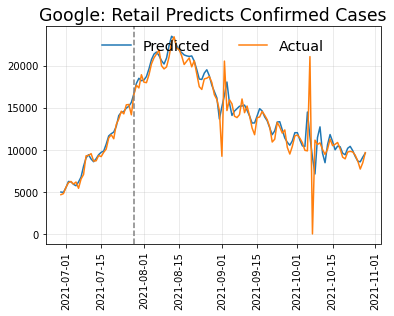

In [112]:
infect = pd.concat([y_multi_retail_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)

plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

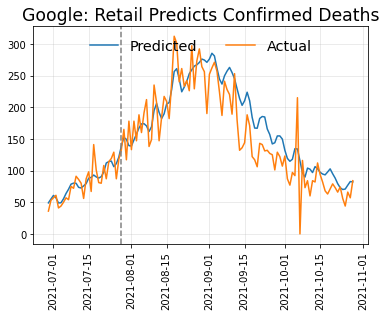

In [113]:
death = pd.concat([y_multi_retail_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [114]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_retail_i1[1],3), round(scores_multi_retail_d1[1],3)],
                                    [round(scores_multi_retail_i[1],3), round(scores_multi_retail_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

# Grocery

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi_grocery = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_tr_grocery, y_i_tr)
    cnn_i_multi_grocery.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr_grocery, y_i_tr)
    cnn_i_multi_grocery.append(score)

cnn_i_multi_grocery = pd.DataFrame(cnn_i_multi_grocery).T
cnn_i_multi_grocery.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi_grocery = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_grocery, y_d_tr)
    cnn_d_multi_grocery.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_grocery, y_d_tr)
    cnn_d_multi_grocery.append(score)

cnn_d_multi_grocery = pd.DataFrame(cnn_d_multi_grocery).T
cnn_d_multi_grocery.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# # Univariate LSTM confirmed cases
units = [2, 4,8,16,32,64,128,256,512, 1024]


# Multivariate LSTM confirmed cases

lstm_i_multi_grocery = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr_grocery, y_i_tr, i)
  lstm_i_multi_grocery.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi_grocery = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr_grocery, y_d_tr, i)
  lstm_d_multi_grocery.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate GRU confirmed cases

gru_i_multi_grocery = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr_grocery, y_i_tr, i)
  gru_i_multi_grocery.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi_grocery = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr_grocery, y_d_tr, i)
  gru_d_multi_grocery.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate RNNs confirmed cases

rnn_i_multi_grocery = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr_grocery, y_i_tr, i)
  rnn_i_multi_grocery.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi_grocery = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr_grocery, y_d_tr, i)
  rnn_d_multi_grocery.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi_grocery[0],3), 
                                     round(gru_i_multi_grocery[0],3),
                                     round(rnn_i_multi_grocery[0],3), 
                                     round(cnn_i_multi_grocery.iloc[0,0],3),
                                     round(cnn_i_multi_grocery.iloc[0,1],3),
                                     round(cnn_i_multi_grocery.iloc[0,2],3),
                                     round(cnn_i_multi_grocery.iloc[0,3],3),
                                     round(cnn_i_multi_grocery.iloc[0,4],3),
                                     round(cnn_i_multi_grocery.iloc[0,5],3)],
                                     [round(lstm_i_multi_grocery[1],3), 
                                     round(gru_i_multi_grocery[1],3),
                                     round(rnn_i_multi_grocery[1],3), 
                                     round(cnn_i_multi_grocery.iloc[1,0],3),
                                     round(cnn_i_multi_grocery.iloc[1,1],3),
                                     round(cnn_i_multi_grocery.iloc[1,2],3),
                                     round(cnn_i_multi_grocery.iloc[1,3],3),
                                     round(cnn_i_multi_grocery.iloc[1,4],3),
                                     round(cnn_i_multi_grocery.iloc[1,5],3)],
                                     [round(lstm_i_multi_grocery[2],3), 
                                     round(gru_i_multi_grocery[2],3),
                                     round(rnn_i_multi_grocery[2],3), 
                                     round(cnn_i_multi_grocery.iloc[2,0],3),
                                     round(cnn_i_multi_grocery.iloc[2,1],3),
                                     round(cnn_i_multi_grocery.iloc[2,2],3),
                                     round(cnn_i_multi_grocery.iloc[2,3],3),
                                     round(cnn_i_multi_grocery.iloc[2,4],3),
                                     round(cnn_i_multi_grocery.iloc[2,5],3)],
                                     [round(lstm_i_multi_grocery[3],3), 
                                     round(gru_i_multi_grocery[3],3),
                                     round(rnn_i_multi_grocery[3],3), 
                                     round(cnn_i_multi_grocery.iloc[3,0],3),
                                     round(cnn_i_multi_grocery.iloc[3,1],3),
                                     round(cnn_i_multi_grocery.iloc[3,2],3),
                                     round(cnn_i_multi_grocery.iloc[3,3],3),
                                     round(cnn_i_multi_grocery.iloc[3,4],3),
                                     round(cnn_i_multi_grocery.iloc[3,5],3)],
                                     [round(lstm_i_multi_grocery[4],3), 
                                     round(gru_i_multi_grocery[4],3),
                                     round(rnn_i_multi_grocery[4],3), 
                                     round(cnn_i_multi_grocery.iloc[4,0],3),
                                     round(cnn_i_multi_grocery.iloc[4,1],3),
                                     round(cnn_i_multi_grocery.iloc[4,2],3),
                                     round(cnn_i_multi_grocery.iloc[4,3],3),
                                     round(cnn_i_multi_grocery.iloc[4,4],3),
                                     round(cnn_i_multi_grocery.iloc[4,5],3)],
                                     [round(lstm_i_multi_grocery[5],3), 
                                     round(gru_i_multi_grocery[5],3),
                                     round(rnn_i_multi_grocery[5],3), 
                                     round(cnn_i_multi_grocery.iloc[5,0],3),
                                     round(cnn_i_multi_grocery.iloc[5,1],3),
                                     round(cnn_i_multi_grocery.iloc[5,2],3),
                                     round(cnn_i_multi_grocery.iloc[5,3],3),
                                     round(cnn_i_multi_grocery.iloc[5,4],3),
                                     round(cnn_i_multi_grocery.iloc[5,5],3)],
                                     [round(lstm_i_multi_grocery[6],3), 
                                     round(gru_i_multi_grocery[6],3),
                                     round(rnn_i_multi_grocery[6],3), 
                                     round(cnn_i_multi_grocery.iloc[6,0],3),
                                     round(cnn_i_multi_grocery.iloc[6,1],3),
                                     round(cnn_i_multi_grocery.iloc[6,2],3),
                                     round(cnn_i_multi_grocery.iloc[6,3],3),
                                     round(cnn_i_multi_grocery.iloc[6,4],3),
                                     round(cnn_i_multi_grocery.iloc[6,5],3)],
                                     [round(lstm_i_multi_grocery[7],3), 
                                     round(gru_i_multi_grocery[7],3),
                                     round(rnn_i_multi_grocery[7],3), 
                                     round(cnn_i_multi_grocery.iloc[7,0],3),
                                     round(cnn_i_multi_grocery.iloc[7,1],3),
                                     round(cnn_i_multi_grocery.iloc[7,2],3),
                                     round(cnn_i_multi_grocery.iloc[7,3],3),
                                     round(cnn_i_multi_grocery.iloc[7,4],3),
                                     round(cnn_i_multi_grocery.iloc[7,5],3)],
                                     [round(lstm_i_multi_grocery[8],3), 
                                     round(gru_i_multi_grocery[8],3),
                                     round(rnn_i_multi_grocery[8],3), 
                                     round(cnn_i_multi_grocery.iloc[8,0],3),
                                     round(cnn_i_multi_grocery.iloc[8,1],3),
                                     round(cnn_i_multi_grocery.iloc[8,2],3),
                                     round(cnn_i_multi_grocery.iloc[8,3],3),
                                     round(cnn_i_multi_grocery.iloc[8,4],3),
                                     round(cnn_i_multi_grocery.iloc[8,5],3)],
                                     [round(lstm_i_multi_grocery[9],3), 
                                     round(gru_i_multi_grocery[9],3),
                                     round(rnn_i_multi_grocery[9],3), 
                                     round(cnn_i_multi_grocery.iloc[9,0],3),
                                     round(cnn_i_multi_grocery.iloc[9,1],3),
                                     round(cnn_i_multi_grocery.iloc[9,2],3),
                                     round(cnn_i_multi_grocery.iloc[9,3],3),
                                     round(cnn_i_multi_grocery.iloc[9,4],3),
                                     round(cnn_i_multi_grocery.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi_grocery[0],3), 
                                     round(gru_d_multi_grocery[0],3),
                                     round(rnn_d_multi_grocery[0],3), 
                                     round(cnn_d_multi_grocery.iloc[0,0],3),
                                     round(cnn_d_multi_grocery.iloc[0,1],3),
                                     round(cnn_d_multi_grocery.iloc[0,2],3),
                                     round(cnn_d_multi_grocery.iloc[0,3],3),
                                     round(cnn_d_multi_grocery.iloc[0,4],3),
                                     round(cnn_d_multi_grocery.iloc[0,5],3)],
                                     [round(lstm_d_multi_grocery[1],3), 
                                     round(gru_d_multi_grocery[1],3),
                                     round(rnn_d_multi_grocery[1],3), 
                                     round(cnn_d_multi_grocery.iloc[1,0],3),
                                     round(cnn_d_multi_grocery.iloc[1,1],3),
                                     round(cnn_d_multi_grocery.iloc[1,2],3),
                                     round(cnn_d_multi_grocery.iloc[1,3],3),
                                     round(cnn_d_multi_grocery.iloc[1,4],3),
                                     round(cnn_d_multi_grocery.iloc[1,5],3)],
                                     [round(lstm_d_multi_grocery[2],3), 
                                     round(gru_d_multi_grocery[2],3),
                                     round(rnn_d_multi_grocery[2],3), 
                                     round(cnn_d_multi_grocery.iloc[2,0],3),
                                     round(cnn_d_multi_grocery.iloc[2,1],3),
                                     round(cnn_d_multi_grocery.iloc[2,2],3),
                                     round(cnn_d_multi_grocery.iloc[2,3],3),
                                     round(cnn_d_multi_grocery.iloc[2,4],3),
                                     round(cnn_d_multi_grocery.iloc[2,5],3)],
                                     [round(lstm_d_multi_grocery[3],3), 
                                     round(gru_d_multi_grocery[3],3),
                                     round(rnn_d_multi_grocery[3],3), 
                                     round(cnn_d_multi_grocery.iloc[3,0],3),
                                     round(cnn_d_multi_grocery.iloc[3,1],3),
                                     round(cnn_d_multi_grocery.iloc[3,2],3),
                                     round(cnn_d_multi_grocery.iloc[3,3],3),
                                     round(cnn_d_multi_grocery.iloc[3,4],3),
                                     round(cnn_d_multi_grocery.iloc[3,5],3)],
                                     [round(lstm_d_multi_grocery[4],3), 
                                     round(gru_d_multi_grocery[4],3),
                                     round(rnn_d_multi_grocery[4],3), 
                                     round(cnn_d_multi_grocery.iloc[4,0],3),
                                     round(cnn_d_multi_grocery.iloc[4,1],3),
                                     round(cnn_d_multi_grocery.iloc[4,2],3),
                                     round(cnn_d_multi_grocery.iloc[4,3],3),
                                     round(cnn_d_multi_grocery.iloc[4,4],3),
                                     round(cnn_d_multi_grocery.iloc[4,5],3)],
                                     [round(lstm_d_multi_grocery[5],3), 
                                     round(gru_d_multi_grocery[5],3),
                                     round(rnn_d_multi_grocery[5],3), 
                                     round(cnn_d_multi_grocery.iloc[5,0],3),
                                     round(cnn_d_multi_grocery.iloc[5,1],3),
                                     round(cnn_d_multi_grocery.iloc[5,2],3),
                                     round(cnn_d_multi_grocery.iloc[5,3],3),
                                     round(cnn_d_multi_grocery.iloc[5,4],3),
                                     round(cnn_d_multi_grocery.iloc[5,5],3)],
                                     [round(lstm_d_multi_grocery[6],3), 
                                     round(gru_d_multi_grocery[6],3),
                                     round(rnn_d_multi_grocery[6],3), 
                                     round(cnn_d_multi_grocery.iloc[6,0],3),
                                     round(cnn_d_multi_grocery.iloc[6,1],3),
                                     round(cnn_d_multi_grocery.iloc[6,2],3),
                                     round(cnn_d_multi_grocery.iloc[6,3],3),
                                     round(cnn_d_multi_grocery.iloc[6,4],3),
                                     round(cnn_d_multi_grocery.iloc[6,5],3)],
                                     [round(lstm_d_multi_grocery[7],3), 
                                     round(gru_d_multi_grocery[7],3),
                                     round(rnn_d_multi_grocery[7],3), 
                                     round(cnn_d_multi_grocery.iloc[7,0],3),
                                     round(cnn_d_multi_grocery.iloc[7,1],3),
                                     round(cnn_d_multi_grocery.iloc[7,2],3),
                                     round(cnn_d_multi_grocery.iloc[7,3],3),
                                     round(cnn_d_multi_grocery.iloc[7,4],3),
                                     round(cnn_d_multi_grocery.iloc[7,5],3)],
                                     [round(lstm_d_multi_grocery[8],3), 
                                     round(gru_d_multi_grocery[8],3),
                                     round(rnn_d_multi_grocery[8],3), 
                                     round(cnn_d_multi_grocery.iloc[8,0],3),
                                     round(cnn_d_multi_grocery.iloc[8,1],3),
                                     round(cnn_d_multi_grocery.iloc[8,2],3),
                                     round(cnn_d_multi_grocery.iloc[8,3],3),
                                     round(cnn_d_multi_grocery.iloc[8,4],3),
                                     round(cnn_d_multi_grocery.iloc[8,5],3)],
                                     [round(lstm_d_multi_grocery[9],3), 
                                     round(gru_d_multi_grocery[9],3),
                                     round(rnn_d_multi_grocery[9],3), 
                                     round(cnn_d_multi_grocery.iloc[9,0],3),
                                     round(cnn_d_multi_grocery.iloc[9,1],3),
                                     round(cnn_d_multi_grocery.iloc[9,2],3),
                                     round(cnn_d_multi_grocery.iloc[9,3],3),
                                     round(cnn_d_multi_grocery.iloc[9,4],3),
                                     round(cnn_d_multi_grocery.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [115]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_grocery_i = Sequential()
# model_multi_grocery_i.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', input_shape=(X_i_tr_grocery.shape[1], X_i_tr_grocery.shape[2])))
# model_multi_grocery_i.add(MaxPooling1D(pool_size = 2))
# model_multi_grocery_i.add(Flatten())
# # model_multi_grocery_i.add(Dense(4, activation = "relu"))
# model_multi_grocery_i.add(Dense(1, activation = "linear"))
# model_multi_grocery_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_grocery_i = Sequential()
model_multi_grocery_i.add(SimpleRNN(128, activation='relu', input_shape=(X_i_tr_grocery.shape[1], X_i_tr_grocery.shape[2])))
model_multi_grocery_i.add(Dense(1, activation = "linear"))
model_multi_grocery_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_grocery_i.fit(X_i_tr_grocery, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_grocery_i1 = model_multi_grocery_i.evaluate(X_i_tr_grocery, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_grocery_i1[1])

scores_multi_grocery_i = model_multi_grocery_i.evaluate(X_i_ts_grocery, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_grocery_i[1])

MAPE: training =  3.0059399604797363
MAPE: test =  10.608474731445312


In [116]:
# make a prediction
# training set
y_multi_grocery_i_tr = pd.DataFrame(model_multi_grocery_i.predict(X_i_tr_grocery))

# test set
y_multi_grocery_i_ts = pd.DataFrame(model_multi_grocery_i.predict(X_i_ts_grocery))

# combine training and test predictions
y_multi_grocery_i_total = pd.concat([y_multi_grocery_i_tr, y_multi_grocery_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [117]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_grocery_d = Sequential()
# model_multi_grocery_d.add(LSTM(8, activation = 'relu', input_shape=(X_d_tr_grocery.shape[1], X_d_tr_grocery.shape[2])))
# model_multi_grocery_d.add(Dense(4, activation = "relu"))
# model_multi_grocery_d.add(Dense(1, activation = "linear"))
# model_multi_grocery_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_grocery_d = Sequential()
model_multi_grocery_d.add(Conv1D(512, kernel_size = 5, activation = 'relu', input_shape=(X_d_tr_grocery.shape[1], X_d_tr_grocery.shape[2])))
model_multi_grocery_d.add(MaxPooling1D(3))
model_multi_grocery_d.add(Flatten())
# model_multi_grocery_d.add(Dense(4, activation = "relu"))
model_multi_grocery_d.add(Dense(1, activation = "linear"))
model_multi_grocery_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_grocery_d.fit(X_d_tr_grocery, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_grocery_d1 = model_multi_grocery_d.evaluate(X_d_tr_grocery, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_grocery_d1[1])

scores_multi_grocery_d = model_multi_grocery_d.evaluate(X_d_ts_grocery, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_grocery_d[1])

MAPE: training =  4.0170674324035645
MAPE: test =  53.94987869262695


In [118]:
# make a prediction
# training set
y_multi_grocery_d_tr = pd.DataFrame(model_multi_grocery_d.predict(X_d_tr_grocery))

# test set
y_multi_grocery_d_ts = pd.DataFrame(model_multi_grocery_d.predict(X_d_ts_grocery))

# combine training and test predictions
y_multi_grocery_d_total = pd.concat([y_multi_grocery_d_tr, y_multi_grocery_d_ts], ignore_index=True)


In [119]:
multi_in = "RNNs"
multi_de = "CNN"
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]

### Plots

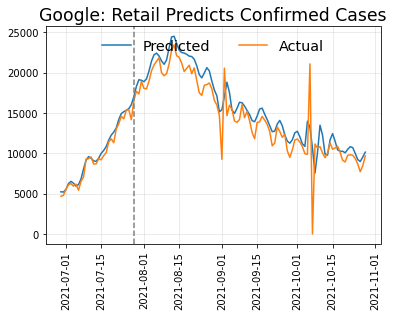

In [120]:
infect = pd.concat([y_multi_grocery_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)

plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

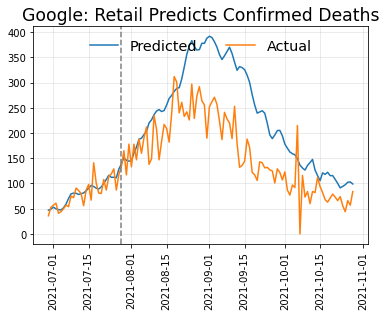

In [121]:
death = pd.concat([y_multi_grocery_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [122]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_grocery_i1[1],3), round(scores_multi_grocery_d1[1],3)],
                                    [round(scores_multi_grocery_i[1],3), round(scores_multi_grocery_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

# Parks

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi_parks = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_tr_parks, y_i_tr)
    cnn_i_multi_parks.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr_parks, y_i_tr)
    cnn_i_multi_parks.append(score)

cnn_i_multi_parks = pd.DataFrame(cnn_i_multi_parks).T
cnn_i_multi_parks.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 5.468
filter = 4, kernel size = 3, pooling size = 2: 5.490
filter = 8, kernel size = 3, pooling size = 2: 5.797
filter = 16, kernel size = 3, pooling size = 2: 4.424
filter = 32, kernel size = 3, pooling size = 2: 4.274
filter = 64, kernel size = 3, pooling size = 2: 3.797
filter = 128, kernel size = 3, pooling size = 2: 3.822
filter = 256, kernel size = 3, pooling size = 2: 4.478
filter = 512, kernel size = 3, pooling size = 2: 4.779
filter = 1024, kernel size = 3, pooling size = 2: 5.396
filter = 2, kernel size = 5, pooling size = 2: 5.570
filter = 4, kernel size = 5, pooling size = 2: 4.703
filter = 8, kernel size = 5, pooling size = 2: 4.427
filter = 16, kernel size = 5, pooling size = 2: 3.341
filter = 32, kernel size = 5, pooling size = 2: 4.355
filter = 64, kernel size = 5, pooling size = 2: 3.912
filter = 128, kernel size = 5, pooling size = 2: 3.879
filter = 256, kernel size = 5, pooling size = 2: 4.470
filter = 512, kernel size =

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi_parks = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_parks, y_d_tr)
    cnn_d_multi_parks.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_parks, y_d_tr)
    cnn_d_multi_parks.append(score)

cnn_d_multi_parks = pd.DataFrame(cnn_d_multi_parks).T
cnn_d_multi_parks.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 11.876
filter = 4, kernel size = 3, pooling size = 2: 11.831
filter = 8, kernel size = 3, pooling size = 2: 9.407
filter = 16, kernel size = 3, pooling size = 2: 9.226
filter = 32, kernel size = 3, pooling size = 2: 8.030
filter = 64, kernel size = 3, pooling size = 2: 5.932
filter = 128, kernel size = 3, pooling size = 2: 5.722
filter = 256, kernel size = 3, pooling size = 2: 5.188
filter = 512, kernel size = 3, pooling size = 2: 4.709
filter = 1024, kernel size = 3, pooling size = 2: 7.270
filter = 2, kernel size = 5, pooling size = 2: 9.633
filter = 4, kernel size = 5, pooling size = 2: 11.175
filter = 8, kernel size = 5, pooling size = 2: 7.930
filter = 16, kernel size = 5, pooling size = 2: 7.996
filter = 32, kernel size = 5, pooling size = 2: 7.895
filter = 64, kernel size = 5, pooling size = 2: 6.798
filter = 128, kernel size = 5, pooling size = 2: 6.938
filter = 256, kernel size = 5, pooling size = 2: 6.464
filter = 512, kernel siz

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# # Univariate LSTM confirmed cases
units = [2, 4,8,16,32,64,128,256,512, 1024]


# Multivariate LSTM confirmed cases

lstm_i_multi_parks = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr_parks, y_i_tr, i)
  lstm_i_multi_parks.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi_parks = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr_grocery, y_d_tr, i)
  lstm_d_multi_parks.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate GRU confirmed cases

gru_i_multi_parks = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr_parks, y_i_tr, i)
  gru_i_multi_parks.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi_parks = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr_parks, y_d_tr, i)
  gru_d_multi_parks.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate RNNs confirmed cases

rnn_i_multi_parks = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr_parks, y_i_tr, i)
  rnn_i_multi_parks.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi_parks = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr_parks, y_d_tr, i)
  rnn_d_multi_parks.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi_parks[0],3), 
                                     round(gru_i_multi_parks[0],3),
                                     round(rnn_i_multi_parks[0],3), 
                                     round(cnn_i_multi_parks.iloc[0,0],3),
                                     round(cnn_i_multi_parks.iloc[0,1],3),
                                     round(cnn_i_multi_parks.iloc[0,2],3),
                                     round(cnn_i_multi_parks.iloc[0,3],3),
                                     round(cnn_i_multi_parks.iloc[0,4],3),
                                     round(cnn_i_multi_parks.iloc[0,5],3)],
                                     [round(lstm_i_multi_parks[1],3), 
                                     round(gru_i_multi_parks[1],3),
                                     round(rnn_i_multi_parks[1],3), 
                                     round(cnn_i_multi_parks.iloc[1,0],3),
                                     round(cnn_i_multi_parks.iloc[1,1],3),
                                     round(cnn_i_multi_parks.iloc[1,2],3),
                                     round(cnn_i_multi_parks.iloc[1,3],3),
                                     round(cnn_i_multi_parks.iloc[1,4],3),
                                     round(cnn_i_multi_parks.iloc[1,5],3)],
                                     [round(lstm_i_multi_parks[2],3), 
                                     round(gru_i_multi_parks[2],3),
                                     round(rnn_i_multi_parks[2],3), 
                                     round(cnn_i_multi_parks.iloc[2,0],3),
                                     round(cnn_i_multi_parks.iloc[2,1],3),
                                     round(cnn_i_multi_parks.iloc[2,2],3),
                                     round(cnn_i_multi_parks.iloc[2,3],3),
                                     round(cnn_i_multi_parks.iloc[2,4],3),
                                     round(cnn_i_multi_parks.iloc[2,5],3)],
                                     [round(lstm_i_multi_parks[3],3), 
                                     round(gru_i_multi_parks[3],3),
                                     round(rnn_i_multi_parks[3],3), 
                                     round(cnn_i_multi_parks.iloc[3,0],3),
                                     round(cnn_i_multi_parks.iloc[3,1],3),
                                     round(cnn_i_multi_parks.iloc[3,2],3),
                                     round(cnn_i_multi_parks.iloc[3,3],3),
                                     round(cnn_i_multi_parks.iloc[3,4],3),
                                     round(cnn_i_multi_parks.iloc[3,5],3)],
                                     [round(lstm_i_multi_parks[4],3), 
                                     round(gru_i_multi_parks[4],3),
                                     round(rnn_i_multi_parks[4],3), 
                                     round(cnn_i_multi_parks.iloc[4,0],3),
                                     round(cnn_i_multi_parks.iloc[4,1],3),
                                     round(cnn_i_multi_parks.iloc[4,2],3),
                                     round(cnn_i_multi_parks.iloc[4,3],3),
                                     round(cnn_i_multi_parks.iloc[4,4],3),
                                     round(cnn_i_multi_parks.iloc[4,5],3)],
                                     [round(lstm_i_multi_parks[5],3), 
                                     round(gru_i_multi_parks[5],3),
                                     round(rnn_i_multi_parks[5],3), 
                                     round(cnn_i_multi_parks.iloc[5,0],3),
                                     round(cnn_i_multi_parks.iloc[5,1],3),
                                     round(cnn_i_multi_parks.iloc[5,2],3),
                                     round(cnn_i_multi_parks.iloc[5,3],3),
                                     round(cnn_i_multi_parks.iloc[5,4],3),
                                     round(cnn_i_multi_parks.iloc[5,5],3)],
                                     [round(lstm_i_multi_parks[6],3), 
                                     round(gru_i_multi_parks[6],3),
                                     round(rnn_i_multi_parks[6],3), 
                                     round(cnn_i_multi_parks.iloc[6,0],3),
                                     round(cnn_i_multi_parks.iloc[6,1],3),
                                     round(cnn_i_multi_parks.iloc[6,2],3),
                                     round(cnn_i_multi_parks.iloc[6,3],3),
                                     round(cnn_i_multi_parks.iloc[6,4],3),
                                     round(cnn_i_multi_parks.iloc[6,5],3)],
                                     [round(lstm_i_multi_parks[7],3), 
                                     round(gru_i_multi_parks[7],3),
                                     round(rnn_i_multi_parks[7],3), 
                                     round(cnn_i_multi_parks.iloc[7,0],3),
                                     round(cnn_i_multi_parks.iloc[7,1],3),
                                     round(cnn_i_multi_parks.iloc[7,2],3),
                                     round(cnn_i_multi_parks.iloc[7,3],3),
                                     round(cnn_i_multi_parks.iloc[7,4],3),
                                     round(cnn_i_multi_parks.iloc[7,5],3)],
                                     [round(lstm_i_multi_parks[8],3), 
                                     round(gru_i_multi_parks[8],3),
                                     round(rnn_i_multi_parks[8],3), 
                                     round(cnn_i_multi_parks.iloc[8,0],3),
                                     round(cnn_i_multi_parks.iloc[8,1],3),
                                     round(cnn_i_multi_parks.iloc[8,2],3),
                                     round(cnn_i_multi_parks.iloc[8,3],3),
                                     round(cnn_i_multi_parks.iloc[8,4],3),
                                     round(cnn_i_multi_parks.iloc[8,5],3)],
                                     [round(lstm_i_multi_parks[9],3), 
                                     round(gru_i_multi_parks[9],3),
                                     round(rnn_i_multi_parks[9],3), 
                                     round(cnn_i_multi_parks.iloc[9,0],3),
                                     round(cnn_i_multi_parks.iloc[9,1],3),
                                     round(cnn_i_multi_parks.iloc[9,2],3),
                                     round(cnn_i_multi_parks.iloc[9,3],3),
                                     round(cnn_i_multi_parks.iloc[9,4],3),
                                     round(cnn_i_multi_parks.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi_parks[0],3), 
                                     round(gru_d_multi_parks[0],3),
                                     round(rnn_d_multi_parks[0],3), 
                                     round(cnn_d_multi_parks.iloc[0,0],3),
                                     round(cnn_d_multi_parks.iloc[0,1],3),
                                     round(cnn_d_multi_parks.iloc[0,2],3),
                                     round(cnn_d_multi_parks.iloc[0,3],3),
                                     round(cnn_d_multi_parks.iloc[0,4],3),
                                     round(cnn_d_multi_parks.iloc[0,5],3)],
                                     [round(lstm_d_multi_parks[1],3), 
                                     round(gru_d_multi_parks[1],3),
                                     round(rnn_d_multi_parks[1],3), 
                                     round(cnn_d_multi_parks.iloc[1,0],3),
                                     round(cnn_d_multi_parks.iloc[1,1],3),
                                     round(cnn_d_multi_parks.iloc[1,2],3),
                                     round(cnn_d_multi_parks.iloc[1,3],3),
                                     round(cnn_d_multi_parks.iloc[1,4],3),
                                     round(cnn_d_multi_parks.iloc[1,5],3)],
                                     [round(lstm_d_multi_parks[2],3), 
                                     round(gru_d_multi_parks[2],3),
                                     round(rnn_d_multi_parks[2],3), 
                                     round(cnn_d_multi_parks.iloc[2,0],3),
                                     round(cnn_d_multi_parks.iloc[2,1],3),
                                     round(cnn_d_multi_parks.iloc[2,2],3),
                                     round(cnn_d_multi_parks.iloc[2,3],3),
                                     round(cnn_d_multi_parks.iloc[2,4],3),
                                     round(cnn_d_multi_parks.iloc[2,5],3)],
                                     [round(lstm_d_multi_parks[3],3), 
                                     round(gru_d_multi_parks[3],3),
                                     round(rnn_d_multi_parks[3],3), 
                                     round(cnn_d_multi_parks.iloc[3,0],3),
                                     round(cnn_d_multi_parks.iloc[3,1],3),
                                     round(cnn_d_multi_parks.iloc[3,2],3),
                                     round(cnn_d_multi_parks.iloc[3,3],3),
                                     round(cnn_d_multi_parks.iloc[3,4],3),
                                     round(cnn_d_multi_parks.iloc[3,5],3)],
                                     [round(lstm_d_multi_parks[4],3), 
                                     round(gru_d_multi_parks[4],3),
                                     round(rnn_d_multi_parks[4],3), 
                                     round(cnn_d_multi_parks.iloc[4,0],3),
                                     round(cnn_d_multi_parks.iloc[4,1],3),
                                     round(cnn_d_multi_parks.iloc[4,2],3),
                                     round(cnn_d_multi_parks.iloc[4,3],3),
                                     round(cnn_d_multi_parks.iloc[4,4],3),
                                     round(cnn_d_multi_parks.iloc[4,5],3)],
                                     [round(lstm_d_multi_parks[5],3), 
                                     round(gru_d_multi_parks[5],3),
                                     round(rnn_d_multi_parks[5],3), 
                                     round(cnn_d_multi_parks.iloc[5,0],3),
                                     round(cnn_d_multi_parks.iloc[5,1],3),
                                     round(cnn_d_multi_parks.iloc[5,2],3),
                                     round(cnn_d_multi_parks.iloc[5,3],3),
                                     round(cnn_d_multi_parks.iloc[5,4],3),
                                     round(cnn_d_multi_parks.iloc[5,5],3)],
                                     [round(lstm_d_multi_parks[6],3), 
                                     round(gru_d_multi_parks[6],3),
                                     round(rnn_d_multi_parks[6],3), 
                                     round(cnn_d_multi_parks.iloc[6,0],3),
                                     round(cnn_d_multi_parks.iloc[6,1],3),
                                     round(cnn_d_multi_parks.iloc[6,2],3),
                                     round(cnn_d_multi_parks.iloc[6,3],3),
                                     round(cnn_d_multi_parks.iloc[6,4],3),
                                     round(cnn_d_multi_parks.iloc[6,5],3)],
                                     [round(lstm_d_multi_parks[7],3), 
                                     round(gru_d_multi_parks[7],3),
                                     round(rnn_d_multi_parks[7],3), 
                                     round(cnn_d_multi_parks.iloc[7,0],3),
                                     round(cnn_d_multi_parks.iloc[7,1],3),
                                     round(cnn_d_multi_parks.iloc[7,2],3),
                                     round(cnn_d_multi_parks.iloc[7,3],3),
                                     round(cnn_d_multi_parks.iloc[7,4],3),
                                     round(cnn_d_multi_parks.iloc[7,5],3)],
                                     [round(lstm_d_multi_parks[8],3), 
                                     round(gru_d_multi_parks[8],3),
                                     round(rnn_d_multi_parks[8],3), 
                                     round(cnn_d_multi_parks.iloc[8,0],3),
                                     round(cnn_d_multi_parks.iloc[8,1],3),
                                     round(cnn_d_multi_parks.iloc[8,2],3),
                                     round(cnn_d_multi_parks.iloc[8,3],3),
                                     round(cnn_d_multi_parks.iloc[8,4],3),
                                     round(cnn_d_multi_parks.iloc[8,5],3)],
                                     [round(lstm_d_multi_parks[9],3), 
                                     round(gru_d_multi_parks[9],3),
                                     round(rnn_d_multi_parks[9],3), 
                                     round(cnn_d_multi_parks.iloc[9,0],3),
                                     round(cnn_d_multi_parks.iloc[9,1],3),
                                     round(cnn_d_multi_parks.iloc[9,2],3),
                                     round(cnn_d_multi_parks.iloc[9,3],3),
                                     round(cnn_d_multi_parks.iloc[9,4],3),
                                     round(cnn_d_multi_parks.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [123]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_parks_i = Sequential()
# model_multi_parks_i.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', input_shape=(X_i_tr_parks.shape[1], X_i_tr_parks.shape[2])))
# model_multi_parks_i.add(MaxPooling1D(pool_size = 2))
# model_multi_parks_i.add(Flatten())
# # model_multi_parks_i.add(Dense(4, activation = "relu"))
# model_multi_parks_i.add(Dense(1, activation = "linear"))
# model_multi_parks_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_parks_i = Sequential()
model_multi_parks_i.add(SimpleRNN(512, activation='relu', input_shape=(X_i_tr_parks.shape[1], X_i_tr_parks.shape[2])))
model_multi_parks_i.add(Dense(1, activation = "linear"))
model_multi_parks_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_parks_i.fit(X_i_tr_parks, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_parks_i1 = model_multi_parks_i.evaluate(X_i_tr_parks, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_parks_i1[1])

scores_multi_parks_i = model_multi_parks_i.evaluate(X_i_ts_parks, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_parks_i[1])

MAPE: training =  3.1707143783569336
MAPE: test =  6.253020286560059


In [124]:
# make a prediction
# training set
y_multi_parks_i_tr = pd.DataFrame(model_multi_parks_i.predict(X_i_tr_parks))

# test set
y_multi_parks_i_ts = pd.DataFrame(model_multi_parks_i.predict(X_i_ts_parks))

# combine training and test predictions
y_multi_parks_i_total = pd.concat([y_multi_parks_i_tr, y_multi_parks_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [125]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_parks_d = Sequential()
model_multi_parks_d.add(LSTM(32, activation = 'relu', input_shape=(X_d_tr_parks.shape[1], X_d_tr_parks.shape[2])))
# model_multi_parks_d.add(Dense(4, activation = "relu"))
model_multi_parks_d.add(Dense(1, activation = "linear"))
model_multi_parks_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# model_multi_parks_d = Sequential()
# model_multi_parks_d.add(Conv1D(32, kernel_size = 3, activation = 'relu', input_shape=(X_d_tr_parks.shape[1], X_d_tr_parks.shape[2])))
# model_multi_parks_d.add(MaxPooling1D(2))
# model_multi_parks_d.add(Flatten())
# # model_multi_parks_d.add(Dense(4, activation = "relu"))
# model_multi_parks_d.add(Dense(1, activation = "linear"))
# model_multi_parks_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_parks_d.fit(X_d_tr_parks, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_parks_d1 = model_multi_parks_d.evaluate(X_d_tr_parks, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_parks_d1[1])

scores_multi_parks_d = model_multi_parks_d.evaluate(X_d_ts_parks, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_parks_d[1])

MAPE: training =  5.685268402099609
MAPE: test =  27.27196502685547


In [126]:
# make a prediction
# training set
y_multi_parks_d_tr = pd.DataFrame(model_multi_parks_d.predict(X_d_tr_parks))

# test set
y_multi_parks_d_ts = pd.DataFrame(model_multi_parks_d.predict(X_d_ts_parks))

# combine training and test predictions
y_multi_parks_d_total = pd.concat([y_multi_parks_d_tr, y_multi_parks_d_ts], ignore_index=True)


In [127]:
multi_in = "RNNs"
multi_de = "LSTM"
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]

### Plots

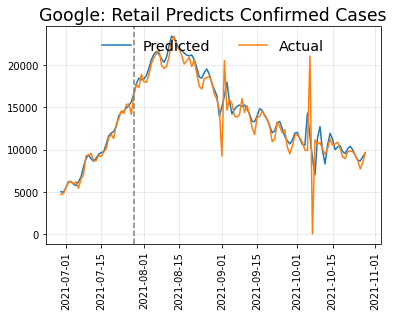

In [128]:
infect = pd.concat([y_multi_parks_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)

plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

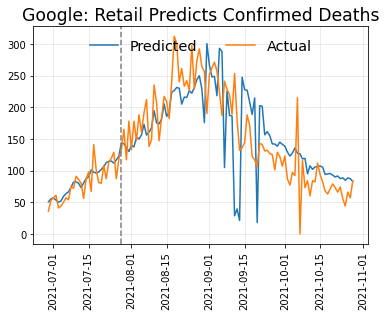

In [129]:
death = pd.concat([y_multi_parks_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [130]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_parks_i1[1],3), round(scores_multi_parks_d1[1],3)],
                                    [round(scores_multi_parks_i[1],3), round(scores_multi_parks_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

# Transit

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi_transit = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_tr_transit, y_i_tr)
    cnn_i_multi_transit.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr_transit, y_i_tr)
    cnn_i_multi_transit.append(score)

cnn_i_multi_transit = pd.DataFrame(cnn_i_multi_transit).T
cnn_i_multi_transit.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 5.479
filter = 4, kernel size = 3, pooling size = 2: 5.474
filter = 8, kernel size = 3, pooling size = 2: 5.766
filter = 16, kernel size = 3, pooling size = 2: 4.419
filter = 32, kernel size = 3, pooling size = 2: 4.264
filter = 64, kernel size = 3, pooling size = 2: 3.800
filter = 128, kernel size = 3, pooling size = 2: 3.837
filter = 256, kernel size = 3, pooling size = 2: 4.516
filter = 512, kernel size = 3, pooling size = 2: 4.866
filter = 1024, kernel size = 3, pooling size = 2: 5.301
filter = 2, kernel size = 5, pooling size = 2: 5.552
filter = 4, kernel size = 5, pooling size = 2: 4.680
filter = 8, kernel size = 5, pooling size = 2: 4.436
filter = 16, kernel size = 5, pooling size = 2: 3.326
filter = 32, kernel size = 5, pooling size = 2: 4.345
filter = 64, kernel size = 5, pooling size = 2: 4.048
filter = 128, kernel size = 5, pooling size = 2: 3.912
filter = 256, kernel size = 5, pooling size = 2: 4.438
filter = 512, kernel size =

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi_transit = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_transit, y_d_tr)
    cnn_d_multi_transit.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_transit, y_d_tr)
    cnn_d_multi_transit.append(score)

cnn_d_multi_transit = pd.DataFrame(cnn_d_multi_transit).T
cnn_d_multi_transit.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 12.574
filter = 4, kernel size = 3, pooling size = 2: 12.311
filter = 8, kernel size = 3, pooling size = 2: 8.375
filter = 16, kernel size = 3, pooling size = 2: 9.900
filter = 32, kernel size = 3, pooling size = 2: 8.563
filter = 64, kernel size = 3, pooling size = 2: 6.561
filter = 128, kernel size = 3, pooling size = 2: 6.391
filter = 256, kernel size = 3, pooling size = 2: 5.721
filter = 512, kernel size = 3, pooling size = 2: 5.071
filter = 1024, kernel size = 3, pooling size = 2: 6.358
filter = 2, kernel size = 5, pooling size = 2: 9.900
filter = 4, kernel size = 5, pooling size = 2: 11.924
filter = 8, kernel size = 5, pooling size = 2: 7.821
filter = 16, kernel size = 5, pooling size = 2: 7.318
filter = 32, kernel size = 5, pooling size = 2: 8.131
filter = 64, kernel size = 5, pooling size = 2: 7.019
filter = 128, kernel size = 5, pooling size = 2: 7.089
filter = 256, kernel size = 5, pooling size = 2: 6.502
filter = 512, kernel siz

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# # Univariate LSTM confirmed cases
units = [2, 4,8,16,32,64,128,256,512, 1024]


# Multivariate LSTM confirmed cases

lstm_i_multi_transit = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr_transit, y_i_tr, i)
  lstm_i_multi_transit.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi_transit = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr_grocery, y_d_tr, i)
  lstm_d_multi_transit.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate GRU confirmed cases

gru_i_multi_transit = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr_transit, y_i_tr, i)
  gru_i_multi_transit.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi_transit = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr_transit, y_d_tr, i)
  gru_d_multi_transit.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate RNNs confirmed cases

rnn_i_multi_transit = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr_transit, y_i_tr, i)
  rnn_i_multi_transit.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi_transit = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr_transit, y_d_tr, i)
  rnn_d_multi_transit.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi_transit[0],3), 
                                     round(gru_i_multi_transit[0],3),
                                     round(rnn_i_multi_transit[0],3), 
                                     round(cnn_i_multi_transit.iloc[0,0],3),
                                     round(cnn_i_multi_transit.iloc[0,1],3),
                                     round(cnn_i_multi_transit.iloc[0,2],3),
                                     round(cnn_i_multi_transit.iloc[0,3],3),
                                     round(cnn_i_multi_transit.iloc[0,4],3),
                                     round(cnn_i_multi_transit.iloc[0,5],3)],
                                     [round(lstm_i_multi_transit[1],3), 
                                     round(gru_i_multi_transit[1],3),
                                     round(rnn_i_multi_transit[1],3), 
                                     round(cnn_i_multi_transit.iloc[1,0],3),
                                     round(cnn_i_multi_transit.iloc[1,1],3),
                                     round(cnn_i_multi_transit.iloc[1,2],3),
                                     round(cnn_i_multi_transit.iloc[1,3],3),
                                     round(cnn_i_multi_transit.iloc[1,4],3),
                                     round(cnn_i_multi_transit.iloc[1,5],3)],
                                     [round(lstm_i_multi_transit[2],3), 
                                     round(gru_i_multi_transit[2],3),
                                     round(rnn_i_multi_transit[2],3), 
                                     round(cnn_i_multi_transit.iloc[2,0],3),
                                     round(cnn_i_multi_transit.iloc[2,1],3),
                                     round(cnn_i_multi_transit.iloc[2,2],3),
                                     round(cnn_i_multi_transit.iloc[2,3],3),
                                     round(cnn_i_multi_transit.iloc[2,4],3),
                                     round(cnn_i_multi_transit.iloc[2,5],3)],
                                     [round(lstm_i_multi_transit[3],3), 
                                     round(gru_i_multi_transit[3],3),
                                     round(rnn_i_multi_transit[3],3), 
                                     round(cnn_i_multi_transit.iloc[3,0],3),
                                     round(cnn_i_multi_transit.iloc[3,1],3),
                                     round(cnn_i_multi_transit.iloc[3,2],3),
                                     round(cnn_i_multi_transit.iloc[3,3],3),
                                     round(cnn_i_multi_transit.iloc[3,4],3),
                                     round(cnn_i_multi_transit.iloc[3,5],3)],
                                     [round(lstm_i_multi_transit[4],3), 
                                     round(gru_i_multi_transit[4],3),
                                     round(rnn_i_multi_transit[4],3), 
                                     round(cnn_i_multi_transit.iloc[4,0],3),
                                     round(cnn_i_multi_transit.iloc[4,1],3),
                                     round(cnn_i_multi_transit.iloc[4,2],3),
                                     round(cnn_i_multi_transit.iloc[4,3],3),
                                     round(cnn_i_multi_transit.iloc[4,4],3),
                                     round(cnn_i_multi_transit.iloc[4,5],3)],
                                     [round(lstm_i_multi_transit[5],3), 
                                     round(gru_i_multi_transit[5],3),
                                     round(rnn_i_multi_transit[5],3), 
                                     round(cnn_i_multi_transit.iloc[5,0],3),
                                     round(cnn_i_multi_transit.iloc[5,1],3),
                                     round(cnn_i_multi_transit.iloc[5,2],3),
                                     round(cnn_i_multi_transit.iloc[5,3],3),
                                     round(cnn_i_multi_transit.iloc[5,4],3),
                                     round(cnn_i_multi_transit.iloc[5,5],3)],
                                     [round(lstm_i_multi_transit[6],3), 
                                     round(gru_i_multi_transit[6],3),
                                     round(rnn_i_multi_transit[6],3), 
                                     round(cnn_i_multi_transit.iloc[6,0],3),
                                     round(cnn_i_multi_transit.iloc[6,1],3),
                                     round(cnn_i_multi_transit.iloc[6,2],3),
                                     round(cnn_i_multi_transit.iloc[6,3],3),
                                     round(cnn_i_multi_transit.iloc[6,4],3),
                                     round(cnn_i_multi_transit.iloc[6,5],3)],
                                     [round(lstm_i_multi_transit[7],3), 
                                     round(gru_i_multi_transit[7],3),
                                     round(rnn_i_multi_transit[7],3), 
                                     round(cnn_i_multi_transit.iloc[7,0],3),
                                     round(cnn_i_multi_transit.iloc[7,1],3),
                                     round(cnn_i_multi_transit.iloc[7,2],3),
                                     round(cnn_i_multi_transit.iloc[7,3],3),
                                     round(cnn_i_multi_transit.iloc[7,4],3),
                                     round(cnn_i_multi_transit.iloc[7,5],3)],
                                     [round(lstm_i_multi_transit[8],3), 
                                     round(gru_i_multi_transit[8],3),
                                     round(rnn_i_multi_transit[8],3), 
                                     round(cnn_i_multi_transit.iloc[8,0],3),
                                     round(cnn_i_multi_transit.iloc[8,1],3),
                                     round(cnn_i_multi_transit.iloc[8,2],3),
                                     round(cnn_i_multi_transit.iloc[8,3],3),
                                     round(cnn_i_multi_transit.iloc[8,4],3),
                                     round(cnn_i_multi_transit.iloc[8,5],3)],
                                     [round(lstm_i_multi_transit[9],3), 
                                     round(gru_i_multi_transit[9],3),
                                     round(rnn_i_multi_transit[9],3), 
                                     round(cnn_i_multi_transit.iloc[9,0],3),
                                     round(cnn_i_multi_transit.iloc[9,1],3),
                                     round(cnn_i_multi_transit.iloc[9,2],3),
                                     round(cnn_i_multi_transit.iloc[9,3],3),
                                     round(cnn_i_multi_transit.iloc[9,4],3),
                                     round(cnn_i_multi_transit.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi_transit[0],3), 
                                     round(gru_d_multi_transit[0],3),
                                     round(rnn_d_multi_transit[0],3), 
                                     round(cnn_d_multi_transit.iloc[0,0],3),
                                     round(cnn_d_multi_transit.iloc[0,1],3),
                                     round(cnn_d_multi_transit.iloc[0,2],3),
                                     round(cnn_d_multi_transit.iloc[0,3],3),
                                     round(cnn_d_multi_transit.iloc[0,4],3),
                                     round(cnn_d_multi_transit.iloc[0,5],3)],
                                     [round(lstm_d_multi_transit[1],3), 
                                     round(gru_d_multi_transit[1],3),
                                     round(rnn_d_multi_transit[1],3), 
                                     round(cnn_d_multi_transit.iloc[1,0],3),
                                     round(cnn_d_multi_transit.iloc[1,1],3),
                                     round(cnn_d_multi_transit.iloc[1,2],3),
                                     round(cnn_d_multi_transit.iloc[1,3],3),
                                     round(cnn_d_multi_transit.iloc[1,4],3),
                                     round(cnn_d_multi_transit.iloc[1,5],3)],
                                     [round(lstm_d_multi_transit[2],3), 
                                     round(gru_d_multi_transit[2],3),
                                     round(rnn_d_multi_transit[2],3), 
                                     round(cnn_d_multi_transit.iloc[2,0],3),
                                     round(cnn_d_multi_transit.iloc[2,1],3),
                                     round(cnn_d_multi_transit.iloc[2,2],3),
                                     round(cnn_d_multi_transit.iloc[2,3],3),
                                     round(cnn_d_multi_transit.iloc[2,4],3),
                                     round(cnn_d_multi_transit.iloc[2,5],3)],
                                     [round(lstm_d_multi_transit[3],3), 
                                     round(gru_d_multi_transit[3],3),
                                     round(rnn_d_multi_transit[3],3), 
                                     round(cnn_d_multi_transit.iloc[3,0],3),
                                     round(cnn_d_multi_transit.iloc[3,1],3),
                                     round(cnn_d_multi_transit.iloc[3,2],3),
                                     round(cnn_d_multi_transit.iloc[3,3],3),
                                     round(cnn_d_multi_transit.iloc[3,4],3),
                                     round(cnn_d_multi_transit.iloc[3,5],3)],
                                     [round(lstm_d_multi_transit[4],3), 
                                     round(gru_d_multi_transit[4],3),
                                     round(rnn_d_multi_transit[4],3), 
                                     round(cnn_d_multi_transit.iloc[4,0],3),
                                     round(cnn_d_multi_transit.iloc[4,1],3),
                                     round(cnn_d_multi_transit.iloc[4,2],3),
                                     round(cnn_d_multi_transit.iloc[4,3],3),
                                     round(cnn_d_multi_transit.iloc[4,4],3),
                                     round(cnn_d_multi_transit.iloc[4,5],3)],
                                     [round(lstm_d_multi_transit[5],3), 
                                     round(gru_d_multi_transit[5],3),
                                     round(rnn_d_multi_transit[5],3), 
                                     round(cnn_d_multi_transit.iloc[5,0],3),
                                     round(cnn_d_multi_transit.iloc[5,1],3),
                                     round(cnn_d_multi_transit.iloc[5,2],3),
                                     round(cnn_d_multi_transit.iloc[5,3],3),
                                     round(cnn_d_multi_transit.iloc[5,4],3),
                                     round(cnn_d_multi_transit.iloc[5,5],3)],
                                     [round(lstm_d_multi_transit[6],3), 
                                     round(gru_d_multi_transit[6],3),
                                     round(rnn_d_multi_transit[6],3), 
                                     round(cnn_d_multi_transit.iloc[6,0],3),
                                     round(cnn_d_multi_transit.iloc[6,1],3),
                                     round(cnn_d_multi_transit.iloc[6,2],3),
                                     round(cnn_d_multi_transit.iloc[6,3],3),
                                     round(cnn_d_multi_transit.iloc[6,4],3),
                                     round(cnn_d_multi_transit.iloc[6,5],3)],
                                     [round(lstm_d_multi_transit[7],3), 
                                     round(gru_d_multi_transit[7],3),
                                     round(rnn_d_multi_transit[7],3), 
                                     round(cnn_d_multi_transit.iloc[7,0],3),
                                     round(cnn_d_multi_transit.iloc[7,1],3),
                                     round(cnn_d_multi_transit.iloc[7,2],3),
                                     round(cnn_d_multi_transit.iloc[7,3],3),
                                     round(cnn_d_multi_transit.iloc[7,4],3),
                                     round(cnn_d_multi_transit.iloc[7,5],3)],
                                     [round(lstm_d_multi_transit[8],3), 
                                     round(gru_d_multi_transit[8],3),
                                     round(rnn_d_multi_transit[8],3), 
                                     round(cnn_d_multi_transit.iloc[8,0],3),
                                     round(cnn_d_multi_transit.iloc[8,1],3),
                                     round(cnn_d_multi_transit.iloc[8,2],3),
                                     round(cnn_d_multi_transit.iloc[8,3],3),
                                     round(cnn_d_multi_transit.iloc[8,4],3),
                                     round(cnn_d_multi_transit.iloc[8,5],3)],
                                     [round(lstm_d_multi_transit[9],3), 
                                     round(gru_d_multi_transit[9],3),
                                     round(rnn_d_multi_transit[9],3), 
                                     round(cnn_d_multi_transit.iloc[9,0],3),
                                     round(cnn_d_multi_transit.iloc[9,1],3),
                                     round(cnn_d_multi_transit.iloc[9,2],3),
                                     round(cnn_d_multi_transit.iloc[9,3],3),
                                     round(cnn_d_multi_transit.iloc[9,4],3),
                                     round(cnn_d_multi_transit.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [131]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_transit_i = Sequential()
# model_multi_transit_i.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', input_shape=(X_i_tr_transit.shape[1], X_i_tr_transit.shape[2])))
# model_multi_transit_i.add(MaxPooling1D(pool_size = 2))
# model_multi_transit_i.add(Flatten())
# # model_multi_transit_i.add(Dense(4, activation = "relu"))
# model_multi_transit_i.add(Dense(1, activation = "linear"))
# model_multi_transit_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_transit_i = Sequential()
model_multi_transit_i.add(SimpleRNN(128, activation='relu', input_shape=(X_i_tr_transit.shape[1], X_i_tr_transit.shape[2])))
model_multi_transit_i.add(Dense(1, activation = "linear"))
model_multi_transit_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_transit_i.fit(X_i_tr_transit, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_transit_i1 = model_multi_transit_i.evaluate(X_i_tr_transit, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_transit_i1[1])

scores_multi_transit_i = model_multi_transit_i.evaluate(X_i_ts_transit, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_transit_i[1])

MAPE: training =  3.0801801681518555
MAPE: test =  9.985441207885742


In [132]:
# make a prediction
# training set
y_multi_transit_i_tr = pd.DataFrame(model_multi_transit_i.predict(X_i_tr_transit))

# test set
y_multi_transit_i_ts = pd.DataFrame(model_multi_transit_i.predict(X_i_ts_transit))

# combine training and test predictions
y_multi_transit_i_total = pd.concat([y_multi_transit_i_tr, y_multi_transit_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [133]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_transit_d = Sequential()
model_multi_transit_d.add(SimpleRNN(128, activation = 'relu', input_shape=(X_d_tr_transit.shape[1], X_d_tr_transit.shape[2])))
# model_multi_transit_d.add(Dense(4, activation = "relu"))
model_multi_transit_d.add(Dense(1, activation = "linear"))
model_multi_transit_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# model_multi_transit_d = Sequential()
# model_multi_transit_d.add(Conv1D(32, kernel_size = 3, activation = 'relu', input_shape=(X_d_tr_transit.shape[1], X_d_tr_transit.shape[2])))
# model_multi_transit_d.add(MaxPooling1D(2))
# model_multi_transit_d.add(Flatten())
# # model_multi_transit_d.add(Dense(4, activation = "relu"))
# model_multi_transit_d.add(Dense(1, activation = "linear"))
# model_multi_transit_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_transit_d.fit(X_d_tr_transit, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_transit_d1 = model_multi_transit_d.evaluate(X_d_tr_transit, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_transit_d1[1])

scores_multi_transit_d = model_multi_transit_d.evaluate(X_d_ts_transit, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_transit_d[1])

MAPE: training =  4.219888210296631
MAPE: test =  14.673185348510742


In [134]:
# make a prediction
# training set
y_multi_transit_d_tr = pd.DataFrame(model_multi_transit_d.predict(X_d_tr_transit))

# test set
y_multi_transit_d_ts = pd.DataFrame(model_multi_transit_d.predict(X_d_ts_transit))

# combine training and test predictions
y_multi_transit_d_total = pd.concat([y_multi_transit_d_tr, y_multi_transit_d_ts], ignore_index=True)


In [135]:
multi_in = "RNNs"
multi_de = "RNNs"
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]

### Plots

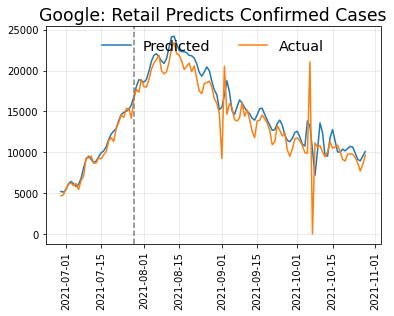

In [136]:
infect = pd.concat([y_multi_transit_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)

plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

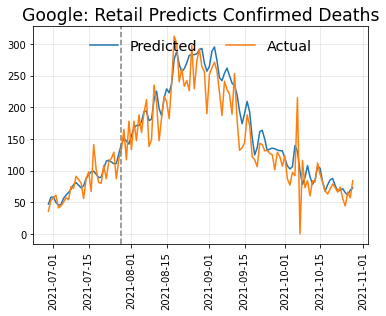

In [137]:
death = pd.concat([y_multi_transit_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [138]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_transit_i1[1],3), round(scores_multi_transit_d1[1],3)],
                                    [round(scores_multi_transit_i[1],3), round(scores_multi_transit_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

# Workplace

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi_workplace = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_tr_workplace, y_i_tr)
    cnn_i_multi_workplace.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr_workplace, y_i_tr)
    cnn_i_multi_workplace.append(score)

cnn_i_multi_workplace = pd.DataFrame(cnn_i_multi_workplace).T
cnn_i_multi_workplace.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 5.494
filter = 4, kernel size = 3, pooling size = 2: 5.493
filter = 8, kernel size = 3, pooling size = 2: 5.845
filter = 16, kernel size = 3, pooling size = 2: 4.422
filter = 32, kernel size = 3, pooling size = 2: 4.246
filter = 64, kernel size = 3, pooling size = 2: 3.740
filter = 128, kernel size = 3, pooling size = 2: 3.645
filter = 256, kernel size = 3, pooling size = 2: 4.064
filter = 512, kernel size = 3, pooling size = 2: 4.706


KeyboardInterrupt: ignored

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi_workplace = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_workplace, y_d_tr)
    cnn_d_multi_workplace.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_workplace, y_d_tr)
    cnn_d_multi_workplace.append(score)

cnn_d_multi_workplace = pd.DataFrame(cnn_d_multi_workplace).T
cnn_d_multi_workplace.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# # Univariate LSTM confirmed cases
units = [2, 4,8,16,32,64,128,256,512, 1024]


# Multivariate LSTM confirmed cases

lstm_i_multi_workplace = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr_workplace, y_i_tr, i)
  lstm_i_multi_workplace.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi_workplace = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr_grocery, y_d_tr, i)
  lstm_d_multi_workplace.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate GRU confirmed cases

gru_i_multi_workplace = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr_workplace, y_i_tr, i)
  gru_i_multi_workplace.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi_workplace = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr_workplace, y_d_tr, i)
  gru_d_multi_workplace.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate RNNs confirmed cases

rnn_i_multi_workplace = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr_workplace, y_i_tr, i)
  rnn_i_multi_workplace.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi_workplace = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr_workplace, y_d_tr, i)
  rnn_d_multi_workplace.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi_workplace[0],3), 
                                     round(gru_i_multi_workplace[0],3),
                                     round(rnn_i_multi_workplace[0],3), 
                                     round(cnn_i_multi_workplace.iloc[0,0],3),
                                     round(cnn_i_multi_workplace.iloc[0,1],3),
                                     round(cnn_i_multi_workplace.iloc[0,2],3),
                                     round(cnn_i_multi_workplace.iloc[0,3],3),
                                     round(cnn_i_multi_workplace.iloc[0,4],3),
                                     round(cnn_i_multi_workplace.iloc[0,5],3)],
                                     [round(lstm_i_multi_workplace[1],3), 
                                     round(gru_i_multi_workplace[1],3),
                                     round(rnn_i_multi_workplace[1],3), 
                                     round(cnn_i_multi_workplace.iloc[1,0],3),
                                     round(cnn_i_multi_workplace.iloc[1,1],3),
                                     round(cnn_i_multi_workplace.iloc[1,2],3),
                                     round(cnn_i_multi_workplace.iloc[1,3],3),
                                     round(cnn_i_multi_workplace.iloc[1,4],3),
                                     round(cnn_i_multi_workplace.iloc[1,5],3)],
                                     [round(lstm_i_multi_workplace[2],3), 
                                     round(gru_i_multi_workplace[2],3),
                                     round(rnn_i_multi_workplace[2],3), 
                                     round(cnn_i_multi_workplace.iloc[2,0],3),
                                     round(cnn_i_multi_workplace.iloc[2,1],3),
                                     round(cnn_i_multi_workplace.iloc[2,2],3),
                                     round(cnn_i_multi_workplace.iloc[2,3],3),
                                     round(cnn_i_multi_workplace.iloc[2,4],3),
                                     round(cnn_i_multi_workplace.iloc[2,5],3)],
                                     [round(lstm_i_multi_workplace[3],3), 
                                     round(gru_i_multi_workplace[3],3),
                                     round(rnn_i_multi_workplace[3],3), 
                                     round(cnn_i_multi_workplace.iloc[3,0],3),
                                     round(cnn_i_multi_workplace.iloc[3,1],3),
                                     round(cnn_i_multi_workplace.iloc[3,2],3),
                                     round(cnn_i_multi_workplace.iloc[3,3],3),
                                     round(cnn_i_multi_workplace.iloc[3,4],3),
                                     round(cnn_i_multi_workplace.iloc[3,5],3)],
                                     [round(lstm_i_multi_workplace[4],3), 
                                     round(gru_i_multi_workplace[4],3),
                                     round(rnn_i_multi_workplace[4],3), 
                                     round(cnn_i_multi_workplace.iloc[4,0],3),
                                     round(cnn_i_multi_workplace.iloc[4,1],3),
                                     round(cnn_i_multi_workplace.iloc[4,2],3),
                                     round(cnn_i_multi_workplace.iloc[4,3],3),
                                     round(cnn_i_multi_workplace.iloc[4,4],3),
                                     round(cnn_i_multi_workplace.iloc[4,5],3)],
                                     [round(lstm_i_multi_workplace[5],3), 
                                     round(gru_i_multi_workplace[5],3),
                                     round(rnn_i_multi_workplace[5],3), 
                                     round(cnn_i_multi_workplace.iloc[5,0],3),
                                     round(cnn_i_multi_workplace.iloc[5,1],3),
                                     round(cnn_i_multi_workplace.iloc[5,2],3),
                                     round(cnn_i_multi_workplace.iloc[5,3],3),
                                     round(cnn_i_multi_workplace.iloc[5,4],3),
                                     round(cnn_i_multi_workplace.iloc[5,5],3)],
                                     [round(lstm_i_multi_workplace[6],3), 
                                     round(gru_i_multi_workplace[6],3),
                                     round(rnn_i_multi_workplace[6],3), 
                                     round(cnn_i_multi_workplace.iloc[6,0],3),
                                     round(cnn_i_multi_workplace.iloc[6,1],3),
                                     round(cnn_i_multi_workplace.iloc[6,2],3),
                                     round(cnn_i_multi_workplace.iloc[6,3],3),
                                     round(cnn_i_multi_workplace.iloc[6,4],3),
                                     round(cnn_i_multi_workplace.iloc[6,5],3)],
                                     [round(lstm_i_multi_workplace[7],3), 
                                     round(gru_i_multi_workplace[7],3),
                                     round(rnn_i_multi_workplace[7],3), 
                                     round(cnn_i_multi_workplace.iloc[7,0],3),
                                     round(cnn_i_multi_workplace.iloc[7,1],3),
                                     round(cnn_i_multi_workplace.iloc[7,2],3),
                                     round(cnn_i_multi_workplace.iloc[7,3],3),
                                     round(cnn_i_multi_workplace.iloc[7,4],3),
                                     round(cnn_i_multi_workplace.iloc[7,5],3)],
                                     [round(lstm_i_multi_workplace[8],3), 
                                     round(gru_i_multi_workplace[8],3),
                                     round(rnn_i_multi_workplace[8],3), 
                                     round(cnn_i_multi_workplace.iloc[8,0],3),
                                     round(cnn_i_multi_workplace.iloc[8,1],3),
                                     round(cnn_i_multi_workplace.iloc[8,2],3),
                                     round(cnn_i_multi_workplace.iloc[8,3],3),
                                     round(cnn_i_multi_workplace.iloc[8,4],3),
                                     round(cnn_i_multi_workplace.iloc[8,5],3)],
                                     [round(lstm_i_multi_workplace[9],3), 
                                     round(gru_i_multi_workplace[9],3),
                                     round(rnn_i_multi_workplace[9],3), 
                                     round(cnn_i_multi_workplace.iloc[9,0],3),
                                     round(cnn_i_multi_workplace.iloc[9,1],3),
                                     round(cnn_i_multi_workplace.iloc[9,2],3),
                                     round(cnn_i_multi_workplace.iloc[9,3],3),
                                     round(cnn_i_multi_workplace.iloc[9,4],3),
                                     round(cnn_i_multi_workplace.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi_workplace[0],3), 
                                     round(gru_d_multi_workplace[0],3),
                                     round(rnn_d_multi_workplace[0],3), 
                                     round(cnn_d_multi_workplace.iloc[0,0],3),
                                     round(cnn_d_multi_workplace.iloc[0,1],3),
                                     round(cnn_d_multi_workplace.iloc[0,2],3),
                                     round(cnn_d_multi_workplace.iloc[0,3],3),
                                     round(cnn_d_multi_workplace.iloc[0,4],3),
                                     round(cnn_d_multi_workplace.iloc[0,5],3)],
                                     [round(lstm_d_multi_workplace[1],3), 
                                     round(gru_d_multi_workplace[1],3),
                                     round(rnn_d_multi_workplace[1],3), 
                                     round(cnn_d_multi_workplace.iloc[1,0],3),
                                     round(cnn_d_multi_workplace.iloc[1,1],3),
                                     round(cnn_d_multi_workplace.iloc[1,2],3),
                                     round(cnn_d_multi_workplace.iloc[1,3],3),
                                     round(cnn_d_multi_workplace.iloc[1,4],3),
                                     round(cnn_d_multi_workplace.iloc[1,5],3)],
                                     [round(lstm_d_multi_workplace[2],3), 
                                     round(gru_d_multi_workplace[2],3),
                                     round(rnn_d_multi_workplace[2],3), 
                                     round(cnn_d_multi_workplace.iloc[2,0],3),
                                     round(cnn_d_multi_workplace.iloc[2,1],3),
                                     round(cnn_d_multi_workplace.iloc[2,2],3),
                                     round(cnn_d_multi_workplace.iloc[2,3],3),
                                     round(cnn_d_multi_workplace.iloc[2,4],3),
                                     round(cnn_d_multi_workplace.iloc[2,5],3)],
                                     [round(lstm_d_multi_workplace[3],3), 
                                     round(gru_d_multi_workplace[3],3),
                                     round(rnn_d_multi_workplace[3],3), 
                                     round(cnn_d_multi_workplace.iloc[3,0],3),
                                     round(cnn_d_multi_workplace.iloc[3,1],3),
                                     round(cnn_d_multi_workplace.iloc[3,2],3),
                                     round(cnn_d_multi_workplace.iloc[3,3],3),
                                     round(cnn_d_multi_workplace.iloc[3,4],3),
                                     round(cnn_d_multi_workplace.iloc[3,5],3)],
                                     [round(lstm_d_multi_workplace[4],3), 
                                     round(gru_d_multi_workplace[4],3),
                                     round(rnn_d_multi_workplace[4],3), 
                                     round(cnn_d_multi_workplace.iloc[4,0],3),
                                     round(cnn_d_multi_workplace.iloc[4,1],3),
                                     round(cnn_d_multi_workplace.iloc[4,2],3),
                                     round(cnn_d_multi_workplace.iloc[4,3],3),
                                     round(cnn_d_multi_workplace.iloc[4,4],3),
                                     round(cnn_d_multi_workplace.iloc[4,5],3)],
                                     [round(lstm_d_multi_workplace[5],3), 
                                     round(gru_d_multi_workplace[5],3),
                                     round(rnn_d_multi_workplace[5],3), 
                                     round(cnn_d_multi_workplace.iloc[5,0],3),
                                     round(cnn_d_multi_workplace.iloc[5,1],3),
                                     round(cnn_d_multi_workplace.iloc[5,2],3),
                                     round(cnn_d_multi_workplace.iloc[5,3],3),
                                     round(cnn_d_multi_workplace.iloc[5,4],3),
                                     round(cnn_d_multi_workplace.iloc[5,5],3)],
                                     [round(lstm_d_multi_workplace[6],3), 
                                     round(gru_d_multi_workplace[6],3),
                                     round(rnn_d_multi_workplace[6],3), 
                                     round(cnn_d_multi_workplace.iloc[6,0],3),
                                     round(cnn_d_multi_workplace.iloc[6,1],3),
                                     round(cnn_d_multi_workplace.iloc[6,2],3),
                                     round(cnn_d_multi_workplace.iloc[6,3],3),
                                     round(cnn_d_multi_workplace.iloc[6,4],3),
                                     round(cnn_d_multi_workplace.iloc[6,5],3)],
                                     [round(lstm_d_multi_workplace[7],3), 
                                     round(gru_d_multi_workplace[7],3),
                                     round(rnn_d_multi_workplace[7],3), 
                                     round(cnn_d_multi_workplace.iloc[7,0],3),
                                     round(cnn_d_multi_workplace.iloc[7,1],3),
                                     round(cnn_d_multi_workplace.iloc[7,2],3),
                                     round(cnn_d_multi_workplace.iloc[7,3],3),
                                     round(cnn_d_multi_workplace.iloc[7,4],3),
                                     round(cnn_d_multi_workplace.iloc[7,5],3)],
                                     [round(lstm_d_multi_workplace[8],3), 
                                     round(gru_d_multi_workplace[8],3),
                                     round(rnn_d_multi_workplace[8],3), 
                                     round(cnn_d_multi_workplace.iloc[8,0],3),
                                     round(cnn_d_multi_workplace.iloc[8,1],3),
                                     round(cnn_d_multi_workplace.iloc[8,2],3),
                                     round(cnn_d_multi_workplace.iloc[8,3],3),
                                     round(cnn_d_multi_workplace.iloc[8,4],3),
                                     round(cnn_d_multi_workplace.iloc[8,5],3)],
                                     [round(lstm_d_multi_workplace[9],3), 
                                     round(gru_d_multi_workplace[9],3),
                                     round(rnn_d_multi_workplace[9],3), 
                                     round(cnn_d_multi_workplace.iloc[9,0],3),
                                     round(cnn_d_multi_workplace.iloc[9,1],3),
                                     round(cnn_d_multi_workplace.iloc[9,2],3),
                                     round(cnn_d_multi_workplace.iloc[9,3],3),
                                     round(cnn_d_multi_workplace.iloc[9,4],3),
                                     round(cnn_d_multi_workplace.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [139]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_workplace_i = Sequential()
# model_multi_workplace_i.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', input_shape=(X_i_tr_workplace.shape[1], X_i_tr_workplace.shape[2])))
# model_multi_workplace_i.add(MaxPooling1D(pool_size = 2))
# model_multi_workplace_i.add(Flatten())
# # model_multi_workplace_i.add(Dense(4, activation = "relu"))
# model_multi_workplace_i.add(Dense(1, activation = "linear"))
# model_multi_workplace_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_workplace_i = Sequential()
model_multi_workplace_i.add(SimpleRNN(512, activation='relu', input_shape=(X_i_tr_workplace.shape[1], X_i_tr_workplace.shape[2])))
model_multi_workplace_i.add(Dense(1, activation = "linear"))
model_multi_workplace_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_workplace_i.fit(X_i_tr_workplace, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_workplace_i1 = model_multi_workplace_i.evaluate(X_i_tr_workplace, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_workplace_i1[1])

scores_multi_workplace_i = model_multi_workplace_i.evaluate(X_i_ts_workplace, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_workplace_i[1])

MAPE: training =  2.6867411136627197
MAPE: test =  6.450926303863525


In [140]:
# make a prediction
# training set
y_multi_workplace_i_tr = pd.DataFrame(model_multi_workplace_i.predict(X_i_tr_workplace))

# test set
y_multi_workplace_i_ts = pd.DataFrame(model_multi_workplace_i.predict(X_i_ts_workplace))

# combine training and test predictions
y_multi_workplace_i_total = pd.concat([y_multi_workplace_i_tr, y_multi_workplace_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [141]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_workplace_d = Sequential()
model_multi_workplace_d.add(SimpleRNN(32, activation = 'relu', input_shape=(X_d_tr_workplace.shape[1], X_d_tr_workplace.shape[2])))
model_multi_workplace_d.add(Dense(4, activation = "relu"))
model_multi_workplace_d.add(Dense(1, activation = "linear"))
model_multi_workplace_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# model_multi_workplace_d = Sequential()
# model_multi_workplace_d.add(Conv1D(32, kernel_size = 3, activation = 'relu', input_shape=(X_d_tr_workplace.shape[1], X_d_tr_workplace.shape[2])))
# model_multi_workplace_d.add(MaxPooling1D(2))
# model_multi_workplace_d.add(Flatten())
# # model_multi_workplace_d.add(Dense(4, activation = "relu"))
# model_multi_workplace_d.add(Dense(1, activation = "linear"))
# model_multi_workplace_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_workplace_d.fit(X_d_tr_workplace, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_workplace_d1 = model_multi_workplace_d.evaluate(X_d_tr_workplace, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_workplace_d1[1])

scores_multi_workplace_d = model_multi_workplace_d.evaluate(X_d_ts_workplace, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_workplace_d[1])

MAPE: training =  5.553162097930908
MAPE: test =  16.044435501098633


In [142]:
# make a prediction
# training set
y_multi_workplace_d_tr = pd.DataFrame(model_multi_workplace_d.predict(X_d_tr_workplace))

# test set
y_multi_workplace_d_ts = pd.DataFrame(model_multi_workplace_d.predict(X_d_ts_workplace))

# combine training and test predictions
y_multi_workplace_d_total = pd.concat([y_multi_workplace_d_tr, y_multi_workplace_d_ts], ignore_index=True)


In [143]:
multi_in = "RNNs"
multi_de = "RNNs"
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]

### Plots

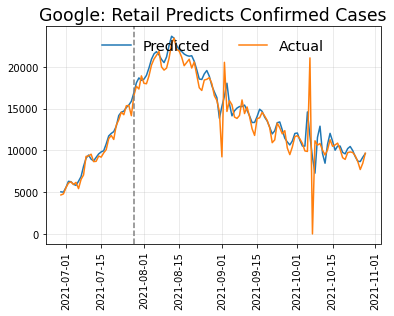

In [144]:
infect = pd.concat([y_multi_workplace_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)

plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

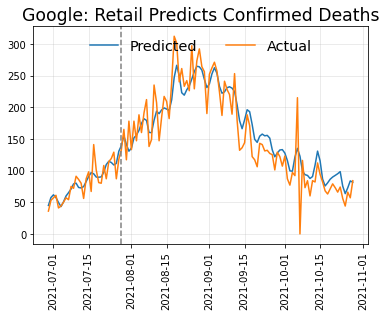

In [145]:
death = pd.concat([y_multi_workplace_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [146]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_workplace_i1[1],3), round(scores_multi_workplace_d1[1],3)],
                                    [round(scores_multi_workplace_i[1],3), round(scores_multi_workplace_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

# Resident

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi_resident = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_tr_resident, y_i_tr)
    cnn_i_multi_resident.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr_resident, y_i_tr)
    cnn_i_multi_resident.append(score)

cnn_i_multi_resident = pd.DataFrame(cnn_i_multi_resident).T
cnn_i_multi_resident.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 5.471
filter = 4, kernel size = 3, pooling size = 2: 5.510
filter = 8, kernel size = 3, pooling size = 2: 5.860
filter = 16, kernel size = 3, pooling size = 2: 4.433
filter = 32, kernel size = 3, pooling size = 2: 4.275
filter = 64, kernel size = 3, pooling size = 2: 3.807
filter = 128, kernel size = 3, pooling size = 2: 3.744
filter = 256, kernel size = 3, pooling size = 2: 4.119
filter = 512, kernel size = 3, pooling size = 2: 4.704
filter = 1024, kernel size = 3, pooling size = 2: 4.902
filter = 2, kernel size = 5, pooling size = 2: 5.612
filter = 4, kernel size = 5, pooling size = 2: 4.763
filter = 8, kernel size = 5, pooling size = 2: 4.483
filter = 16, kernel size = 5, pooling size = 2: 3.432
filter = 32, kernel size = 5, pooling size = 2: 4.370
filter = 64, kernel size = 5, pooling size = 2: 3.873
filter = 128, kernel size = 5, pooling size = 2: 3.752
filter = 256, kernel size = 5, pooling size = 2: 3.999
filter = 512, kernel size =

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi_resident = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_resident, y_d_tr)
    cnn_d_multi_resident.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_resident, y_d_tr)
    cnn_d_multi_resident.append(score)

cnn_d_multi_resident = pd.DataFrame(cnn_d_multi_resident).T
cnn_d_multi_resident.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 10.777
filter = 4, kernel size = 3, pooling size = 2: 8.141
filter = 8, kernel size = 3, pooling size = 2: 9.481
filter = 16, kernel size = 3, pooling size = 2: 8.906
filter = 32, kernel size = 3, pooling size = 2: 7.754
filter = 64, kernel size = 3, pooling size = 2: 7.359
filter = 128, kernel size = 3, pooling size = 2: 8.910
filter = 256, kernel size = 3, pooling size = 2: 10.822
filter = 512, kernel size = 3, pooling size = 2: 11.365
filter = 1024, kernel size = 3, pooling size = 2: 11.532
filter = 2, kernel size = 5, pooling size = 2: 9.292
filter = 4, kernel size = 5, pooling size = 2: 8.983
filter = 8, kernel size = 5, pooling size = 2: 7.830
filter = 16, kernel size = 5, pooling size = 2: 8.387
filter = 32, kernel size = 5, pooling size = 2: 7.671
filter = 64, kernel size = 5, pooling size = 2: 8.266
filter = 128, kernel size = 5, pooling size = 2: 9.808
filter = 256, kernel size = 5, pooling size = 2: 12.560
filter = 512, kernel s

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# # Univariate LSTM confirmed cases
units = [2, 4,8,16,32,64,128,256,512, 1024]


# Multivariate LSTM confirmed cases

lstm_i_multi_resident = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr_resident, y_i_tr, i)
  lstm_i_multi_resident.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi_resident = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr_grocery, y_d_tr, i)
  lstm_d_multi_resident.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate GRU confirmed cases

gru_i_multi_resident = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr_resident, y_i_tr, i)
  gru_i_multi_resident.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi_resident = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr_resident, y_d_tr, i)
  gru_d_multi_resident.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate RNNs confirmed cases

rnn_i_multi_resident = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr_resident, y_i_tr, i)
  rnn_i_multi_resident.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi_resident = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr_resident, y_d_tr, i)
  rnn_d_multi_resident.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi_resident[0],3), 
                                     round(gru_i_multi_resident[0],3),
                                     round(rnn_i_multi_resident[0],3), 
                                     round(cnn_i_multi_resident.iloc[0,0],3),
                                     round(cnn_i_multi_resident.iloc[0,1],3),
                                     round(cnn_i_multi_resident.iloc[0,2],3),
                                     round(cnn_i_multi_resident.iloc[0,3],3),
                                     round(cnn_i_multi_resident.iloc[0,4],3),
                                     round(cnn_i_multi_resident.iloc[0,5],3)],
                                     [round(lstm_i_multi_resident[1],3), 
                                     round(gru_i_multi_resident[1],3),
                                     round(rnn_i_multi_resident[1],3), 
                                     round(cnn_i_multi_resident.iloc[1,0],3),
                                     round(cnn_i_multi_resident.iloc[1,1],3),
                                     round(cnn_i_multi_resident.iloc[1,2],3),
                                     round(cnn_i_multi_resident.iloc[1,3],3),
                                     round(cnn_i_multi_resident.iloc[1,4],3),
                                     round(cnn_i_multi_resident.iloc[1,5],3)],
                                     [round(lstm_i_multi_resident[2],3), 
                                     round(gru_i_multi_resident[2],3),
                                     round(rnn_i_multi_resident[2],3), 
                                     round(cnn_i_multi_resident.iloc[2,0],3),
                                     round(cnn_i_multi_resident.iloc[2,1],3),
                                     round(cnn_i_multi_resident.iloc[2,2],3),
                                     round(cnn_i_multi_resident.iloc[2,3],3),
                                     round(cnn_i_multi_resident.iloc[2,4],3),
                                     round(cnn_i_multi_resident.iloc[2,5],3)],
                                     [round(lstm_i_multi_resident[3],3), 
                                     round(gru_i_multi_resident[3],3),
                                     round(rnn_i_multi_resident[3],3), 
                                     round(cnn_i_multi_resident.iloc[3,0],3),
                                     round(cnn_i_multi_resident.iloc[3,1],3),
                                     round(cnn_i_multi_resident.iloc[3,2],3),
                                     round(cnn_i_multi_resident.iloc[3,3],3),
                                     round(cnn_i_multi_resident.iloc[3,4],3),
                                     round(cnn_i_multi_resident.iloc[3,5],3)],
                                     [round(lstm_i_multi_resident[4],3), 
                                     round(gru_i_multi_resident[4],3),
                                     round(rnn_i_multi_resident[4],3), 
                                     round(cnn_i_multi_resident.iloc[4,0],3),
                                     round(cnn_i_multi_resident.iloc[4,1],3),
                                     round(cnn_i_multi_resident.iloc[4,2],3),
                                     round(cnn_i_multi_resident.iloc[4,3],3),
                                     round(cnn_i_multi_resident.iloc[4,4],3),
                                     round(cnn_i_multi_resident.iloc[4,5],3)],
                                     [round(lstm_i_multi_resident[5],3), 
                                     round(gru_i_multi_resident[5],3),
                                     round(rnn_i_multi_resident[5],3), 
                                     round(cnn_i_multi_resident.iloc[5,0],3),
                                     round(cnn_i_multi_resident.iloc[5,1],3),
                                     round(cnn_i_multi_resident.iloc[5,2],3),
                                     round(cnn_i_multi_resident.iloc[5,3],3),
                                     round(cnn_i_multi_resident.iloc[5,4],3),
                                     round(cnn_i_multi_resident.iloc[5,5],3)],
                                     [round(lstm_i_multi_resident[6],3), 
                                     round(gru_i_multi_resident[6],3),
                                     round(rnn_i_multi_resident[6],3), 
                                     round(cnn_i_multi_resident.iloc[6,0],3),
                                     round(cnn_i_multi_resident.iloc[6,1],3),
                                     round(cnn_i_multi_resident.iloc[6,2],3),
                                     round(cnn_i_multi_resident.iloc[6,3],3),
                                     round(cnn_i_multi_resident.iloc[6,4],3),
                                     round(cnn_i_multi_resident.iloc[6,5],3)],
                                     [round(lstm_i_multi_resident[7],3), 
                                     round(gru_i_multi_resident[7],3),
                                     round(rnn_i_multi_resident[7],3), 
                                     round(cnn_i_multi_resident.iloc[7,0],3),
                                     round(cnn_i_multi_resident.iloc[7,1],3),
                                     round(cnn_i_multi_resident.iloc[7,2],3),
                                     round(cnn_i_multi_resident.iloc[7,3],3),
                                     round(cnn_i_multi_resident.iloc[7,4],3),
                                     round(cnn_i_multi_resident.iloc[7,5],3)],
                                     [round(lstm_i_multi_resident[8],3), 
                                     round(gru_i_multi_resident[8],3),
                                     round(rnn_i_multi_resident[8],3), 
                                     round(cnn_i_multi_resident.iloc[8,0],3),
                                     round(cnn_i_multi_resident.iloc[8,1],3),
                                     round(cnn_i_multi_resident.iloc[8,2],3),
                                     round(cnn_i_multi_resident.iloc[8,3],3),
                                     round(cnn_i_multi_resident.iloc[8,4],3),
                                     round(cnn_i_multi_resident.iloc[8,5],3)],
                                     [round(lstm_i_multi_resident[9],3), 
                                     round(gru_i_multi_resident[9],3),
                                     round(rnn_i_multi_resident[9],3), 
                                     round(cnn_i_multi_resident.iloc[9,0],3),
                                     round(cnn_i_multi_resident.iloc[9,1],3),
                                     round(cnn_i_multi_resident.iloc[9,2],3),
                                     round(cnn_i_multi_resident.iloc[9,3],3),
                                     round(cnn_i_multi_resident.iloc[9,4],3),
                                     round(cnn_i_multi_resident.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi_resident[0],3), 
                                     round(gru_d_multi_resident[0],3),
                                     round(rnn_d_multi_resident[0],3), 
                                     round(cnn_d_multi_resident.iloc[0,0],3),
                                     round(cnn_d_multi_resident.iloc[0,1],3),
                                     round(cnn_d_multi_resident.iloc[0,2],3),
                                     round(cnn_d_multi_resident.iloc[0,3],3),
                                     round(cnn_d_multi_resident.iloc[0,4],3),
                                     round(cnn_d_multi_resident.iloc[0,5],3)],
                                     [round(lstm_d_multi_resident[1],3), 
                                     round(gru_d_multi_resident[1],3),
                                     round(rnn_d_multi_resident[1],3), 
                                     round(cnn_d_multi_resident.iloc[1,0],3),
                                     round(cnn_d_multi_resident.iloc[1,1],3),
                                     round(cnn_d_multi_resident.iloc[1,2],3),
                                     round(cnn_d_multi_resident.iloc[1,3],3),
                                     round(cnn_d_multi_resident.iloc[1,4],3),
                                     round(cnn_d_multi_resident.iloc[1,5],3)],
                                     [round(lstm_d_multi_resident[2],3), 
                                     round(gru_d_multi_resident[2],3),
                                     round(rnn_d_multi_resident[2],3), 
                                     round(cnn_d_multi_resident.iloc[2,0],3),
                                     round(cnn_d_multi_resident.iloc[2,1],3),
                                     round(cnn_d_multi_resident.iloc[2,2],3),
                                     round(cnn_d_multi_resident.iloc[2,3],3),
                                     round(cnn_d_multi_resident.iloc[2,4],3),
                                     round(cnn_d_multi_resident.iloc[2,5],3)],
                                     [round(lstm_d_multi_resident[3],3), 
                                     round(gru_d_multi_resident[3],3),
                                     round(rnn_d_multi_resident[3],3), 
                                     round(cnn_d_multi_resident.iloc[3,0],3),
                                     round(cnn_d_multi_resident.iloc[3,1],3),
                                     round(cnn_d_multi_resident.iloc[3,2],3),
                                     round(cnn_d_multi_resident.iloc[3,3],3),
                                     round(cnn_d_multi_resident.iloc[3,4],3),
                                     round(cnn_d_multi_resident.iloc[3,5],3)],
                                     [round(lstm_d_multi_resident[4],3), 
                                     round(gru_d_multi_resident[4],3),
                                     round(rnn_d_multi_resident[4],3), 
                                     round(cnn_d_multi_resident.iloc[4,0],3),
                                     round(cnn_d_multi_resident.iloc[4,1],3),
                                     round(cnn_d_multi_resident.iloc[4,2],3),
                                     round(cnn_d_multi_resident.iloc[4,3],3),
                                     round(cnn_d_multi_resident.iloc[4,4],3),
                                     round(cnn_d_multi_resident.iloc[4,5],3)],
                                     [round(lstm_d_multi_resident[5],3), 
                                     round(gru_d_multi_resident[5],3),
                                     round(rnn_d_multi_resident[5],3), 
                                     round(cnn_d_multi_resident.iloc[5,0],3),
                                     round(cnn_d_multi_resident.iloc[5,1],3),
                                     round(cnn_d_multi_resident.iloc[5,2],3),
                                     round(cnn_d_multi_resident.iloc[5,3],3),
                                     round(cnn_d_multi_resident.iloc[5,4],3),
                                     round(cnn_d_multi_resident.iloc[5,5],3)],
                                     [round(lstm_d_multi_resident[6],3), 
                                     round(gru_d_multi_resident[6],3),
                                     round(rnn_d_multi_resident[6],3), 
                                     round(cnn_d_multi_resident.iloc[6,0],3),
                                     round(cnn_d_multi_resident.iloc[6,1],3),
                                     round(cnn_d_multi_resident.iloc[6,2],3),
                                     round(cnn_d_multi_resident.iloc[6,3],3),
                                     round(cnn_d_multi_resident.iloc[6,4],3),
                                     round(cnn_d_multi_resident.iloc[6,5],3)],
                                     [round(lstm_d_multi_resident[7],3), 
                                     round(gru_d_multi_resident[7],3),
                                     round(rnn_d_multi_resident[7],3), 
                                     round(cnn_d_multi_resident.iloc[7,0],3),
                                     round(cnn_d_multi_resident.iloc[7,1],3),
                                     round(cnn_d_multi_resident.iloc[7,2],3),
                                     round(cnn_d_multi_resident.iloc[7,3],3),
                                     round(cnn_d_multi_resident.iloc[7,4],3),
                                     round(cnn_d_multi_resident.iloc[7,5],3)],
                                     [round(lstm_d_multi_resident[8],3), 
                                     round(gru_d_multi_resident[8],3),
                                     round(rnn_d_multi_resident[8],3), 
                                     round(cnn_d_multi_resident.iloc[8,0],3),
                                     round(cnn_d_multi_resident.iloc[8,1],3),
                                     round(cnn_d_multi_resident.iloc[8,2],3),
                                     round(cnn_d_multi_resident.iloc[8,3],3),
                                     round(cnn_d_multi_resident.iloc[8,4],3),
                                     round(cnn_d_multi_resident.iloc[8,5],3)],
                                     [round(lstm_d_multi_resident[9],3), 
                                     round(gru_d_multi_resident[9],3),
                                     round(rnn_d_multi_resident[9],3), 
                                     round(cnn_d_multi_resident.iloc[9,0],3),
                                     round(cnn_d_multi_resident.iloc[9,1],3),
                                     round(cnn_d_multi_resident.iloc[9,2],3),
                                     round(cnn_d_multi_resident.iloc[9,3],3),
                                     round(cnn_d_multi_resident.iloc[9,4],3),
                                     round(cnn_d_multi_resident.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [147]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_resident_i = Sequential()
# model_multi_resident_i.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', input_shape=(X_i_tr_resident.shape[1], X_i_tr_resident.shape[2])))
# model_multi_resident_i.add(MaxPooling1D(pool_size = 2))
# model_multi_resident_i.add(Flatten())
# # model_multi_resident_i.add(Dense(4, activation = "relu"))
# model_multi_resident_i.add(Dense(1, activation = "linear"))
# model_multi_resident_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_resident_i = Sequential()
model_multi_resident_i.add(SimpleRNN(256, activation='relu', input_shape=(X_i_tr_resident.shape[1], X_i_tr_resident.shape[2])))
model_multi_resident_i.add(Dense(1, activation = "linear"))
model_multi_resident_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_resident_i.fit(X_i_tr_resident, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_resident_i1 = model_multi_resident_i.evaluate(X_i_tr_resident, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_resident_i1[1])

scores_multi_resident_i = model_multi_resident_i.evaluate(X_i_ts_resident, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_resident_i[1])

MAPE: training =  3.156494140625
MAPE: test =  8.280495643615723


In [148]:
# make a prediction
# training set
y_multi_resident_i_tr = pd.DataFrame(model_multi_resident_i.predict(X_i_tr_resident))

# test set
y_multi_resident_i_ts = pd.DataFrame(model_multi_resident_i.predict(X_i_ts_resident))

# combine training and test predictions
y_multi_resident_i_total = pd.concat([y_multi_resident_i_tr, y_multi_resident_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [149]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_resident_d = Sequential()
model_multi_resident_d.add(SimpleRNN(512, activation = 'relu', input_shape=(X_d_tr_resident.shape[1], X_d_tr_resident.shape[2])))
# model_multi_resident_d.add(Dense(4, activation = "relu"))
model_multi_resident_d.add(Dense(1, activation = "linear"))
model_multi_resident_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# model_multi_resident_d = Sequential()
# model_multi_resident_d.add(Conv1D(32, kernel_size = 3, activation = 'relu', input_shape=(X_d_tr_resident.shape[1], X_d_tr_resident.shape[2])))
# model_multi_resident_d.add(MaxPooling1D(2))
# model_multi_resident_d.add(Flatten())
# # model_multi_resident_d.add(Dense(4, activation = "relu"))
# model_multi_resident_d.add(Dense(1, activation = "linear"))
# model_multi_resident_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_resident_d.fit(X_d_tr_resident, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_resident_d1 = model_multi_resident_d.evaluate(X_d_tr_resident, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_resident_d1[1])

scores_multi_resident_d = model_multi_resident_d.evaluate(X_d_ts_resident, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_resident_d[1])

MAPE: training =  4.822949409484863
MAPE: test =  8.368539810180664


In [150]:
# make a prediction
# training set
y_multi_resident_d_tr = pd.DataFrame(model_multi_resident_d.predict(X_d_tr_resident))

# test set
y_multi_resident_d_ts = pd.DataFrame(model_multi_resident_d.predict(X_d_ts_resident))

# combine training and test predictions
y_multi_resident_d_total = pd.concat([y_multi_resident_d_tr, y_multi_resident_d_ts], ignore_index=True)


In [151]:
multi_in = "RNNs"
multi_de = "RNNs"
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]

### Plots

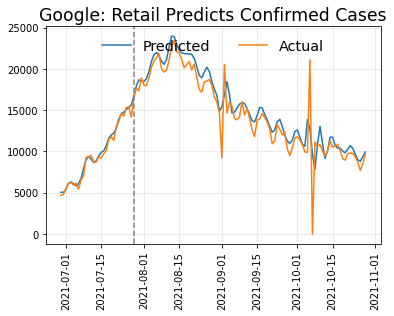

In [152]:
infect = pd.concat([y_multi_resident_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)

plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

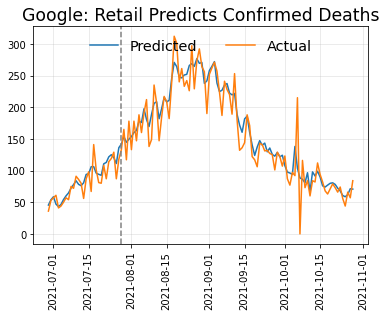

In [153]:
death = pd.concat([y_multi_resident_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Predicts Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [154]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_resident_i1[1],3), round(scores_multi_resident_d1[1],3)],
                                    [round(scores_multi_resident_i[1],3), round(scores_multi_resident_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()